# Import 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import qutip as qt
from copy import deepcopy
import scipy as sp
from scipy.optimize import curve_fit


import experiments as meas
from experiments.MM_dual_rail_base import MM_dual_rail_base
from fitting.fit_display_classes import GeneralFitting
from fitting.wigner import WignerAnalysis

from slab import AttrDict
from experiments import MultimodeStation, CharacterizationRunner, SweepRunner

from job_server import JobClient
from job_server.database import get_database
from job_server.config_versioning import ConfigVersionManager

# Initialize database and config manager
db = get_database()
config_dir = 'D:/python/multimode_expts/configs'
config_manager = ConfigVersionManager(config_dir)

# Initialize job client (handle submitting and waiting for jobs)
client = JobClient()

# Check server health
health = client.health_check()
print(f"Server status: {health['status']}")
print(f"Pending jobs: {health['pending_jobs']}")

user = "seb"
print("Welcome", user)


station = MultimodeStation(
    user=user,
    experiment_name = "250119_qec",
)

active_reset_dict = {
    'active_reset': True, # on recalibration of readout, turn off active reset because it will be wrong for selecting when to apply the qubit pulse
    'ef_reset': True,
    'storage_reset': False,
    'coupler_reset': False,
    'pre_selection_reset': True,
    'man_reset': False, 
    'use_qubit_man_reset': True, # whether to use the qubit
    'pre_selection_parity':True,
}


USE_QUEUE = True
mm_base_calib = MM_dual_rail_base(station.hardware_cfg, station.soc)

Failed to read module file 'D:\python\multimode_expts\.pixi\envs\default\Lib\pydoc_data\topics.py' for module 'pydoc_data.topics': UnicodeDecodeError
Traceback (most recent call last):
  File "D:\python\multimode_expts\.pixi\envs\default\Lib\site-packages\IPython\core\extensions.py", line 62, in load_extension
    return self._load_extension(module_str)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\python\multimode_expts\.pixi\envs\default\Lib\site-packages\IPython\core\extensions.py", line 77, in _load_extension
    mod = import_module(module_str)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\python\multimode_expts\.pixi\envs\default\Lib\importlib\__init__.py", line 90, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1387, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._boo

Importing all classes from  D:\python\multimode_expts\experiments\dual_rail
Importing all classes from  D:\python\multimode_expts\experiments\qsim
Importing all classes from  D:\python\multimode_expts\experiments\qubit_cavity
Importing all classes from  D:\python\multimode_expts\experiments\single_qubit
Skipped top-level files ['characterization_runner.py', 'dataset.py', 'MM_base.py', 'MM_dual_rail_base.py', 'MM_rb_base.py', 'mock_hardware.py', 'sequential_experiment.py', 'sequential_experiment_classes.py', 'station.py', 'sweep_runner.py']
Server status: healthy
Pending jobs: 0
Welcome seb
[STATION] Using main hardware_config version: CFG-HW-20260223-00015
[STATION] Using main multiphoton_config version: CFG-MP-20260121-00001
[STATION] Using main man1_storage_swap version: CFG-M1-20260224-00019
[STATION] Using main floquet_storage_swap version: CFG-FL-20260223-00023
Data, plots, logs will be stored in: D:\experiments\250119_qec
Hardware configs will be read from D:\python\multimode_exp

# Calibrate single shot 

In [2]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
singleshot_defaults = AttrDict(dict(    
    reps=5000,
    relax_delay=500,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=400,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    qubits=[0],
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values



def singleshot_postproc(station, expt):
    expt.analyze(plot=False, station=station, subdir=station.autocalib_path)
    fids = expt.data['fids']
    confusion_matrix = expt.data['confusion_matrix']
    thresholds_new = expt.data['thresholds']
    angle = expt.data['angle']
    print(fids)

    hardware_cfg = station.hardware_cfg
    hardware_cfg.device.readout.phase = [hardware_cfg.device.readout.phase[0] + angle]
    hardware_cfg.device.readout.threshold = thresholds_new
    hardware_cfg.device.readout.threshold_list = [thresholds_new]
    hardware_cfg.device.readout.Ie = [np.median(expt.data['Ie_rot'])]
    hardware_cfg.device.readout.Ig = [np.median(expt.data['Ig_rot'])]
    if expt.cfg.expt.active_reset:
        hardware_cfg.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        hardware_cfg.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

    expt.display(station)


single_shot_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.HistogramExperiment,
    default_expt_cfg = singleshot_defaults,
    postprocessor = singleshot_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

Failed to read module file 'D:\python\multimode_expts\experiments\qsim\t2_cavity_fluxexcursion.py' for module 'experiments.qsim.t2_cavity_fluxexcursion': UnicodeDecodeError
Traceback (most recent call last):
  File "D:\python\multimode_expts\.pixi\envs\default\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 219, in update_sources
    self.source_by_modname[new_modname] = f.read()
                                          ^^^^^^^^
  File "D:\python\multimode_expts\.pixi\envs\default\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 3793: character maps to <undefined>


Job submitted: JOB-20260224-00442 (queue position: 1)

[0.1s] Job JOB-20260224-00442: pending

[2.1s] Job JOB-20260224-00442: running
[WORKER] Loading HistogramExperiment from experiments.single_qubit.single_shot
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00442_HistogramExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
 66%|████████████████████████▏            | 3276/5000 [00:08<00:04, 399.48it/s]
[32.9s] Job JOB-20260224-00442: completed
100%|█████████████████████████████████████| 5000/5000 [00:12<00:00, 399.40it/s]
Unrotated:
Ig 115.01216216216216 +/- 89.11172064667856 	 Qg -485.57297297297293 +/- 73.17315999036354 	 Amp g 499.00792531484603
Ie 423.4837837837838 +/- 79.18118755676247 	 Qe -145.3527027027027 +/- 98.6105944979598 	 Amp e 447.7342105656109
Rotated:
Ig -286.1218437555351 +/- 91.23660391122546 	 Qg -411.90793319358113 +/- 70.50597

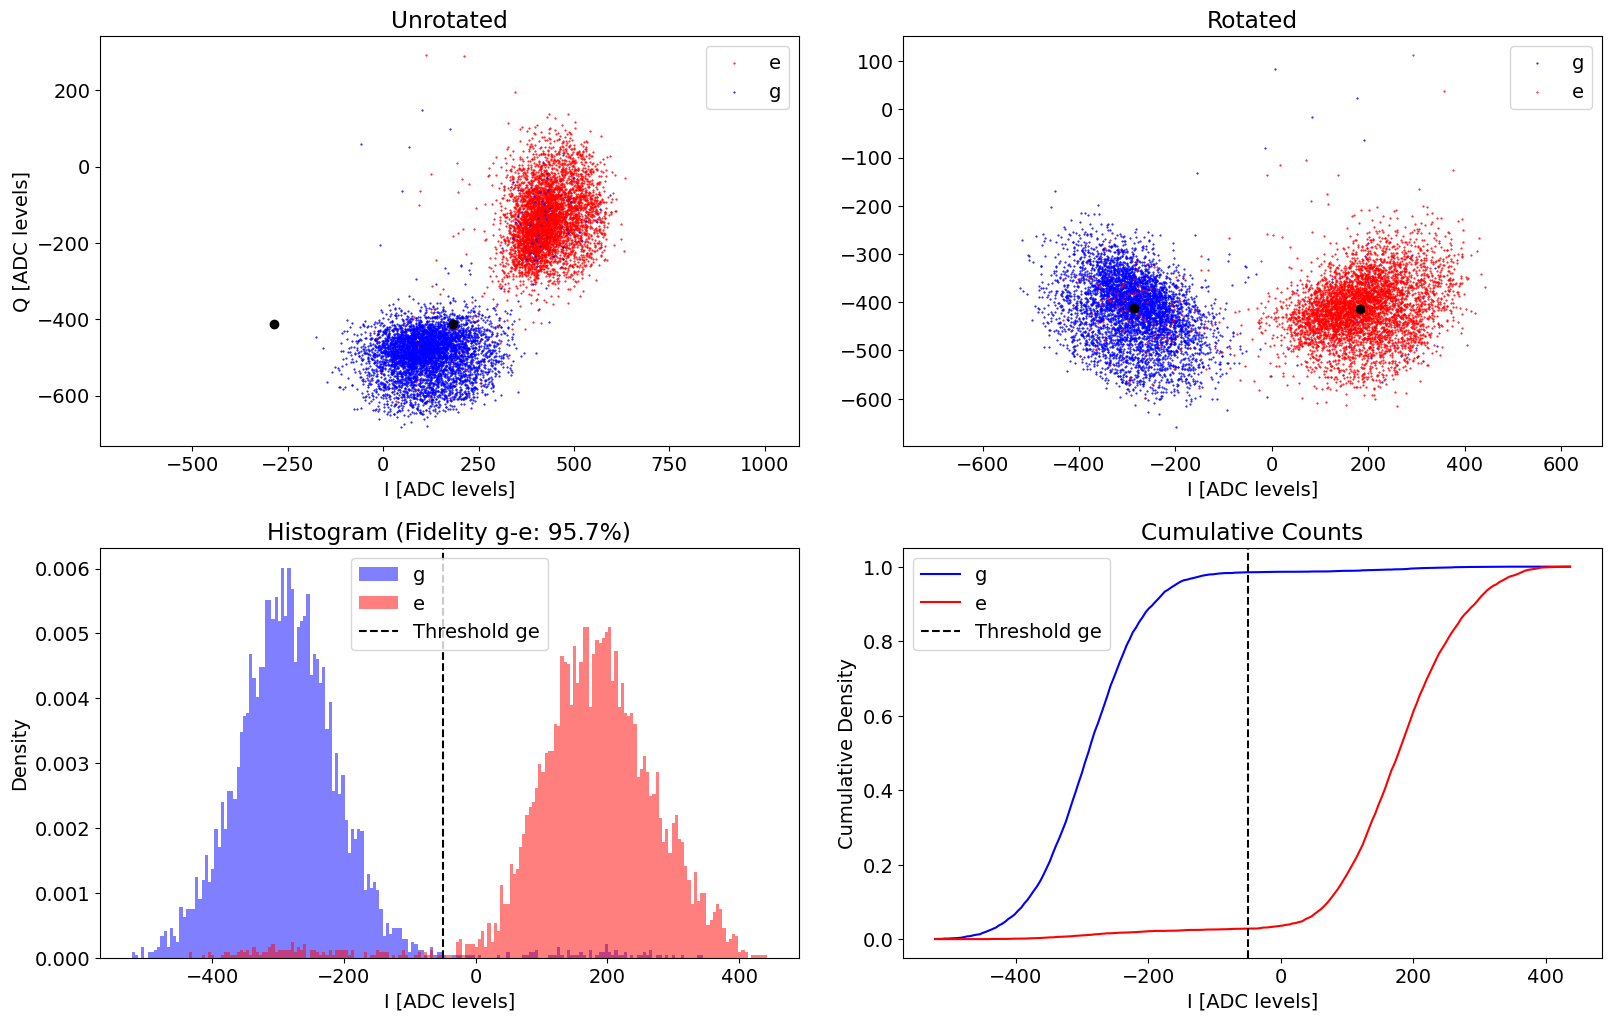

Plot saved to D:\experiments\250119_qec\plots\2026-02-24_17-33-00_histogram.png
Plot reference appended to D:\experiments\250119_qec\logs\2026-02-24.md
ge fidelity (%): 95.69999999999997
rotation angle (deg): -47.80196690118029
threshold ge: -49.88462085625201


In [3]:
single_shot = single_shot_runner.execute(
        go_kwargs=dict(analyze=False, display=False),
        check_f=False,
        relax_delay=2500,
        gate_based=False,
        # **active_reset_dict,
    )

# Calibrate the beam splitter 

In [ ]:
from joint_parity_calibrator import JointParityCalibrator
calibrator = JointParityCalibrator(station, client, use_queue=USE_QUEUE, debug=True)

In [ ]:
man_mode_no = 1
stor_mode_no = 3
nb_points = 11
length_range_frac = (1, 1.3)

calibrator._build_gain_sweep_vectors(man_mode_no, stor_mode_no, nb_points, length_range_frac=length_range_frac)

In [ ]:

# Run calibration and fit (one call does everything)
lookup_result = calibrator.calibrate_bs_rate_lookup_table(
    man_mode_no=man_mode_no,
    stor_mode_no=stor_mode_no,
    qubit_states=('g','e'),
    # qubit_states=('e'),
    # num_pts=11,
    num_pts=nb_points,
    reps=50,
    degree_rate=4,
    degree_freq=4,
    freq_span_initial=0.13,
    freq_span_final=0.075,
    gain_span_frac=0.2,
    n_pulses=6,
    n_step=2,
    length_range_frac=length_range_frac
)

In [ ]:
# If the fit doesn't look good, refit with different polynomial degrees (no re-running experiments):
calibrator.fit_bs_rate_lookup_table(lookup_result, degree_rate=3, degree_freq=5, skip_indices=[9])

# station.ds_storage.get_bs_rate_coeffs('M1-S2')



In [ ]:
station.snapshot_man1_storage_swap(update_main=True)

# Calibrate the flat top pi pulse length 

### First calibrate the pi pulse gain for a given length and flat top sigma.

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
amprabi_defaults = AttrDict(dict(
    start=0,
    step=60,
    expts=151,
    reps=200,
    rounds=1,
    sigma_test=0.1,
    qubit=0,
    pulse_type='flat_top',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    postpulse=False, 
    if_ef=False,  # If true, will check ef frequency and update it
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

def amprabi_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    # Copied over but what's all this below????
    # Which ones are actually used? 
    # Can we straighten out all the nested boolean logic???
    pulse_ge = station.hardware_cfg.device.qubit.pulses.pi_ge
    if expt_cfg.sigma_test is None:
        expt_cfg.sigma_test = pulse_ge.sigma[0]
    if expt_cfg.step is None:
        expt_cfg.step = int(pulse_ge.gain[0] / (expt_cfg.expts - 1))
    
    expt_cfg.checkEF = False
    expt_cfg.pulse_ge_init = False
    expt_cfg.pulse_ge_after = False
    if expt_cfg.if_ef:
        expt_cfg.checkEF = True
        expt_cfg.pulse_ge_init = True
        expt_cfg.pulse_ge_after = True
    
    return expt_cfg

def amprabi_postproc(station, expt):
    station.hardware_cfg.device.qubit.pulses.pi_ge.gain = [expt.data['pi_gain_avgi']]
    station.hardware_cfg.device.qubit.pulses.hpi_ge.gain = [expt.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')

In [ ]:
# Execute
# =================================
amprabi_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.AmplitudeRabiExperiment,
    default_expt_cfg = amprabi_defaults,
    # preprocessor = amprabi_preproc,
    # postprocessor = amprabi_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

In [ ]:
N_qubit = 1 # number of 2pi rotation on the qubit 
N_bs = 3 # number of 2pi rotation on the beam splitter
man_mode_no = 1
chi_ge = station.hardware_cfg.device.manipulate.chi_ge[man_mode_no - 1]
# g_bs_guess = np.abs(chi_ge) * ((N_bs**2 - N_qubit**2) / (4*N_qubit**2 - 1))**1/2
# Tp = 1 / np.abs(chi_ge) * (4*N_qubit**2 - 1)** 1/2 * (1 - 1/(4*N_bs**2))**(-1/2)

g_bs_guess = np.sqrt(3)/2*chi_ge
Tp = np.pi/(4*g_bs_guess)

print(f"Initial guess for beam-splitter rate: {g_bs_guess:.4f} MHz")
print(f"Initial guess for beam-splitter pulse length: {Tp:.4f} us")

gain_qb_pi_pulse = station.hardware_cfg.device.qubit.pulses.pi_ge.gain[0]
sigma_qb_pi_pulse = station.hardware_cfg.device.qubit.pulses.pi_ge.sigma[0]
pi_pulse_type = station.hardware_cfg.device.qubit.pulses.pi_ge.type[0]
assert pi_pulse_type == 'gauss', "Only gaussian pi pulse is supported for now"
n=4 # assume the pulse is 4 sigma long
theta_to_gain = np.pi/2/gain_qb_pi_pulse
drive_to_gain_qb = sigma_qb_pi_pulse * np.sqrt(np.pi)/theta_to_gain * sp.special.erf(n/2)
length_to_gain = drive_to_gain_qb / 4

sigma_flat_top = 0.025
nb_point = 1

length_vec = np.linspace(1, 1, 1)*Tp
gain_guess = int(length_to_gain/min(length_vec)*8)
gain_vec = np.zeros(len(length_vec))
print("Length vec:", length_vec)
print('gain guess', gain_guess)

In [ ]:
expts = 100 
step = gain_guess//expts

for idx, length in enumerate(length_vec):
    try:
        print(f"Length: {length}")
        amprabi = amprabi_runner.execute(
            go_kwargs=dict(analyze=True, display=True),
            flat_length=length,
            sigma_test=sigma_flat_top,
            step = step, 
            expts = expts,
            start=10,
        )

        gain_fit = amprabi.data['pi_gain_avgi']
        gain_vec[idx] = gain_fit
        print(f"Fitted gain: {gain_fit}")

        if USE_QUEUE:
            amprabi.display()

    except Exception as e:
        print(f"Error at length {length}: {e}")
        gain_vec[idx] = np.nan  # Mark this point as NaN to indicate failure
    

In [ ]:
fig, ax = plt.subplots()
ax.plot(length_vec, gain_vec, marker='o')
ax.set_xlabel('Pulse Length (us)')
ax.set_ylabel('Fitted Gain')
ax.set_title('Fitted Gain vs Pulse Length')


### Then do the photon number resolved spectroscopy

In [ ]:
photon_number_spectro_defaults = AttrDict(dict(
    start=3560, 
    step=0.1,
    expts=200,
    reps=2000,
    rounds=1,
    length=1,
    gain=400,
    sigma=0.1,
    qubits=[0],
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,
))

photon_number_spectro_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment,
    default_expt_cfg=photon_number_spectro_defaults,
    job_client=client,
    use_queue=USE_QUEUE,
)

In [ ]:
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=1)
pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, station.hardware_cfg).pulse.tolist()
print(f"pre_sweep_pulse: {pre_sweep_pulse}")

In [ ]:
span = 1
expt = 100
step = span / expt
start = station.hardware_cfg.device.qubit.f_ge[0] - span*0.8
length = 15


for idx, length in enumerate(length_vec):

    try:
        photon_number_spectro_g = photon_number_spectro_runner.execute(
            go_kwargs=dict(analyze=True, display=True, save=True),
            pre_sweep_pulse=pre_sweep_pulse,
            prepulse=False,
            gate_based=False,
            start=start,
            length=length,
            sigma=sigma_flat_top,
            gain=int(gain_vec[idx]),
            step=step,
            expts=expt,
            relax_delay=500,
        )

        if USE_QUEUE:
            photon_number_spectro_g.display()

        photon_number_spectro_e = photon_number_spectro_runner.execute(
        go_kwargs=dict(analyze=True, display=True, save=True),
        pre_sweep_pulse=pre_sweep_pulse,
        prepulse=True,
        gate_based=False,
        start=start,
        length=length,
        sigma=sigma_flat_top,
        gain=int(gain_vec[idx]),
        step=step,
        expts=expt,
        relax_delay=500,
        )

        if USE_QUEUE:
            photon_number_spectro_e.display()




    except Exception as e:
        print(f"Error at length {length}: {e}")


In [ ]:
x_g = photon_number_spectro_g.data['xpts']
x_e = photon_number_spectro_e.data['xpts']
y_g =  photon_number_spectro_g.data['avgi']
y_e =  photon_number_spectro_e.data['avgi']
diff = np.abs(y_g - y_e)

fig, ax = plt.subplots()
ax.plot(x_g, y_g, '-o', label='Qubit in $|g\\rangle$', color='tab:blue')
ax.plot(x_e, y_e, '-o', label='Qubit in $|e\\rangle$', color='tab:red')


In [ ]:
old_gain = station.hardware_cfg.device.qubit.pulses.very_slow_pi_ge.gain[0]
old_sigma = station.hardware_cfg.device.qubit.pulses.very_slow_pi_ge.sigma[0]
old_length = station.hardware_cfg.device.qubit.pulses.very_slow_pi_ge.length[0]

station.hardware_cfg.device.qubit.pulses.very_slow_pi_ge.gain[0] = int(gain_fit)
station.hardware_cfg.device.qubit.pulses.very_slow_pi_ge.sigma[0] = sigma_flat_top
station.hardware_cfg.device.qubit.pulses.very_slow_pi_ge.length[0] = length_vec[0]

In [ ]:
station.preview_config_update()
station.snapshot_hardware_config(update_main=True)

# Calibrate the joint parity measurement 

In [ ]:
from joint_parity_calibrator import JointParityCalibrator
calibrator = JointParityCalibrator(station, client, use_queue=USE_QUEUE, debug=True)

In [ ]:
station.ds_storage.get_gain_at_bs_rate(stor_name, g_bs_guess, 'g')

In [ ]:
man_mode_no = 1
stor_mode_no = 3
swap_mode_no = 1
stor_name = f'M1-S{stor_mode_no}'
chi_ge = station.hardware_cfg.device.manipulate.chi_ge[man_mode_no - 1]

g_bs_guess = np.sqrt(3)/2 * np.abs(chi_ge) * 0.5
# Build gain list from a rate guess
# gain_center = 4000
gain_center = station.ds_storage.get_gain_at_bs_rate(stor_name, g_bs_guess, 'g')
gain_list = np.linspace(int(gain_center * 0.95), int(gain_center * 1.15), 9).astype(int) 

print(f"Initial guess for beam-splitter rate: {g_bs_guess:.4f} MHz")
print(f"Initial guess for gain from rate guess: {gain_center}")
print(f"Testing gains around: {gain_list}")

In [ ]:
alice = calibrator.sweep_beam_splitter_rate_parity(
    gain_list=gain_list,
    storage_swap=swap_mode_no,
    stor_mode_no=stor_mode_no,
    reps_parity=250,
    # reps_parity=100,
    fit_degree=3,
    # reps_rabi = 500,
    reps_rabi = 250,
)

In [ ]:
refit=False

if refit: 
    refit = calibrator.fit_gain_sweep_parity(alice, fit_degree=2, skip_indices=[0, 7])
    alice.update(refit)
    # Propagate into fitted_calibration
    alice['fitted_calibration']['phase_01_optimal'] = refit['phase_01_optimal']


In [ ]:
if refit:
    fitted_cal = calibrator.calibrate_at_fitted_gain(
        alice, refit['fitted_optimal_gain'],
        man_mode_no=1, stor_mode_no=2,
        rabi_reps=500,
    )

In [ ]:
if refit:
    alice['fitted_calibration'] = fitted_cal
    best = alice['optimal_result']

In [ ]:
bob = calibrator.calibrate_wait_time_parity(
    wait_time_list=alice['fitted_calibration']['pi_length'] * np.linspace(0.9, 1.1, 9) * 2,
    # wait_time_list=3.45 * np.linspace(0.9, 1.1, 15) * 2,
    fixed_params=alice['fitted_calibration'],
    storage_swap=swap_mode_no,
    # target_phase=alice['fitted_calibration']['phase_01_optimal'] - (232.8 - 217.6),
    reps=100,
)

In [ ]:
freq_bs = alice['fitted_calibration']['freq_bs']
gain = alice['fitted_calibration']['gain']
pi_length = alice['fitted_calibration']['pi_length']
wait_time = bob['fitted_optimal_wait'] 


print(f"Final fitted parameters for storage mode S{stor_mode_no}:")
print(f"Beam-splitter frequency: {freq_bs:.4f} MHz")
print(f"Beam-splitter gain: {gain:.2f}")
print(f"Pi pulse length: {pi_length:.4f} us")
print(f"Optimal wait time: {wait_time:.4f} us")


In [ ]:
station.ds_storage.update_joint_parity(
    stor_name=stor_name,
    freq_bs=freq_bs,
    gain=gain,
    length=pi_length * 2,
    wait_time=wait_time
)
print(f"Stored joint parity params for {stor_name}: freq={freq_bs:.4f} MHz, gain={gain}, length={pi_length*2:.4f} us, wait_time={wait_time} us")

# Optionally snapshot to save to config version
station.snapshot_man1_storage_swap(update_main=True)
# station.preview_config_update()

# Check the joint parity measurement

In [37]:
# 1. Define defaults
parity_phase_defaults = AttrDict(dict(
    # Phase sweep parameters
    start=0,
    step=3.6,  # 100 points over 360 degrees
    expts=100,
    # Averaging
    reps=200,
    rounds=1,
    # Storage modes
    storage_swap=3,      # M1-S3 - swapped to/from manipulate
    storage_parity=1,    # M1-S1 - probed by joint parity (NOT swapped)
    manipulate=1,
    # State preparation: '00', '10', '01', or '11'
    state_start='00',
    # Pulse mode
    parity_fast=True,
    # Reset options
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    # Optional prepulse
    prepulse=False,
    gate_based=False,
    # Qubit selection
    qubits=[0],
    relax_delay=2500,
))


# 2. Optional postprocessor (extract results, update config)
def parity_phase_postproc(station, expt):
    # Example: extract fitted phase offset if needed
    if 'fit_avgi' in expt.data:
        phase_offset = expt.data['fit_avgi'][2]  # phase parameter from sin fit
        print(f"Fitted phase offset: {phase_offset:.2f} deg")
    return None

# 3. Create the runner
parity_phase_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ParityPhaseExperiment,
    default_expt_cfg=parity_phase_defaults,
    postprocessor=parity_phase_postproc,  # optional
    job_client=client,
    use_queue=USE_QUEUE,
)




Job submitted: JOB-20260224-00371 (queue position: 1)

[0.1s] Job JOB-20260224-00371: pending

[26.7s] Job JOB-20260224-00371: running
[WORKER] Loading ParityPhaseExperiment from experiments.dual_rail.parity_phase
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00371_ParityPhaseExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
States:   0%|                                            | 0/4 [00:00<?, ?it/s]
=== Running state_start='10' ===
State preparation sequence for state_start='10': [['multiphoton', 'g0-e0', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0], ['multiphoton', 'f0-g1', 'pi', 0], ['storage', 'M1-S7', 'pi', 0]]

States:  25%|█████████                           | 1/4 [01:03<03:10, 63.51s/it]
=== Running state_start='01' ===
State preparation sequence for state_start='01': [['multiphoton', 'g0-e0', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0],

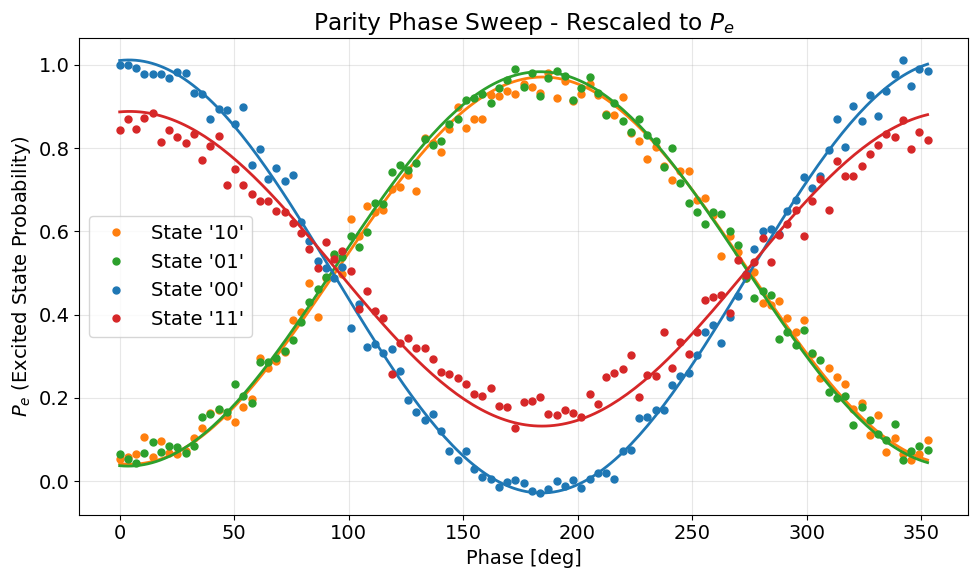


=== Fit Summary ===
State '10': period=360.0 deg, phase=265.3 deg, amplitude=0.465, offset=0.506
State '01': period=360.0 deg, phase=266.4 deg, amplitude=0.474, offset=0.510
State '00': period=360.0 deg, phase=86.0 deg, amplitude=0.520, offset=0.492
State '11': period=360.0 deg, phase=85.6 deg, amplitude=0.378, offset=0.510


In [40]:
# 5. Execute with optional overrides
parity_phase_expt = parity_phase_runner.execute(
    # Override any defaults via kwargs:
    storage_swap=7,
    storage_parity=6,
    # storage_swap=swap_mode_no,
    # storage_parity=stor_mode_no,
    state_start=['10', '01', '00', '11'],  # '00', '10', '01', or '11'
    reps=250,
    go_kwargs=dict(analyze=True, display=True),
    parity_fast=False,
    **active_reset_dict,
)

# If using queue, display results manually
if USE_QUEUE:
    parity_phase_expt.analyze()
    parity_phase_expt.display()

# Dual-rail experiments

## Sandbox

In [ ]:
# ============================================
# Dual Rail Sandbox Experiment
# ============================================

# 1. Define defaults
dual_rail_sandbox_defaults = AttrDict(dict(
    # Averaging
    reps=500,
    rounds=1,
    # Storage modes for dual rail
    storage_1=1,             # First storage mode (e.g., S1)
    storage_2=3,             # Second storage mode (e.g., S3)
    manipulate=1,            # Manipulate mode
    # State preparation: '00', '10', '01', '11' or list
    state_start='00',
    # Wait and parity options
    wait_time=0,             # Wait time in us (0 = skip)
    repeat_count=1,          # Number of (wait + joint_parity) loops
    parity_flag=False,       # If True, measure joint parity during repeat
    parity_fast=False,       # If True, use fast multiphoton hpi pulses
    # Reset options
    active_reset=False,
    reset_before_dual_rail=False,
    reset_after_dual_rail=False,
    # Qubit selection
    qubits=[0],
    relax_delay=10000,
))


# 2. Optional postprocessor
def dual_rail_sandbox_postproc(station, expt):
    """Post-process dual rail sandbox results."""
    # Analyze with post-selection
    expt.analyze(post_select=True)
    
    # Print summary
    state_list = expt.data.get('states', ['00'])
    for state in state_list:
        pops = expt.data.get(f'pop_{state}', {})
        post_count = expt.data.get(f'post_select_count_{state}', expt.cfg.expt.reps)
        print(f"State |{state}>: 00={pops.get('00',0):.3f}, 10={pops.get('10',0):.3f}, "
              f"01={pops.get('01',0):.3f}, 11={pops.get('11',0):.3f} "
              f"(post-sel: {post_count}/{expt.cfg.expt.reps})")
    return None


# 3. Create the runner
dual_rail_sandbox_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.DualRailSandboxExperiment,
    default_expt_cfg=dual_rail_sandbox_defaults,
    postprocessor=dual_rail_sandbox_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)



In [ ]:
wait_list = np.arange(0, 6000+60, 60)
# wait_list = np.arange(0, 6000, 1000)
wait_list = 0
print('wait_list:', wait_list)

In [ ]:
station.ds_storage.df

In [ ]:
# storage_1 = [1, 4, 6]
# storage_2 = [3, 2, 7]

storage_parity = [1, 2, 6]
storage_swap = [3, 4, 7]

# storage_1 = [6]
# storage_2 = [7]



for s1, s2 in zip(storage_swap, storage_parity):

    # single_shot = single_shot_runner.execute(
    #     go_kwargs=dict(analyze=False, display=False),
    #     check_f=False,
    #     relax_delay=2500,
    #     gate_based=False,
    #     # **active_reset_dict,
    # )
    
    print(f"Testing storage modes: {s1} and {s2}")
    # 4. Execute - Basic state preparation test (no joint parity)
    dual_rail_expt = dual_rail_sandbox_runner.execute(
        state_start=['00', '01', '10', '11'],  # Logical states
        storage_swap=s1,
        storage_parity=s2,
        wait_time=wait_list,
        parity_flag=False,
        reset_before_dual_rail=True,
        measure_parity=True,
        reps=1000,
        go_kwargs=dict(analyze=False, display=False),
        **active_reset_dict,
        prep_postselect=False, 
        prep_ps_parity=False,
    )

    # If using queue, analyze and display manually
    if USE_QUEUE:
        dual_rail_expt.analyze(post_select=True)
        if wait_list == 0:
            dual_rail_expt.display(show_iq=True, show_histograms=True, log_scale=True)
        else: 
            dual_rail_expt.display(show_iq=False, show_histograms=False, log_scale=True)





## Ramsey

In [4]:
# ============================================
# Dual Rail Ramsey Experiment
# ============================================

# from experiments.dual_rail.dual_rail_ramsey import DualRailRamseyExperiment

# 1. Define defaults
dual_rail_ramsey_defaults = AttrDict(dict(
    # Sweep parameters
    start=0.1,               # us, initial wait time
    step=0.5,                # us, wait time increment (Nyquist: 1/step > 2*ramsey_freq)
    expts=100,               # number of sweep points
    ramsey_freq=0.5,         # MHz, virtual detuning frequency
    # Averaging
    reps=250,
    rounds=1,
    # Storage modes for dual rail (sandbox_v2 convention)
    storage_swap=1,          # S_swap: logical |1> (e.g., S1)
    storage_parity=3,        # S_parity: logical |0> (e.g., S3)
    manipulate=1,            # Manipulate mode
    # State preparation: '+', '-', '+i', '-i', '0', '1', or list e.g. ['+', '-']
    state_start='+',
    # Echo configuration
    echoes=0,                # 0 = Ramsey, N>0 = N echo pulses
    echo_gate='Y',           # Gate for echo pulse ('X', 'Y', 'X/2', etc.)
    # Measurement options
    measure_parity=True,     # True for parity, False for slow pi
    reset_before_dual_rail=False,
    reset_after_dual_rail=False,
    # Reset options
    # **active_reset_dict,
    active_reset=False,
    # Qubit selection
    qubits=[0],
    relax_delay=2500,
))


# 2. Optional postprocessor
def dual_rail_ramsey_postproc(station, expt):
    """Post-process dual rail Ramsey results."""
    expt.analyze(fit=True)

    state_list = expt.data.get('states', ['+'])
    for state in state_list:
        fit_p1 = expt.data.get(f'fit_p1_{state}')
        if fit_p1 is not None:
            print(f"State |{state}>: T2 Ramsey = {fit_p1[3]:.4g} us, "
                  f"fit freq = {fit_p1[1]:.6g} MHz")
    return None


# 3. Create the runner
dual_rail_ramsey_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.DualRailRamseyExperiment,
    default_expt_cfg=dual_rail_ramsey_defaults,
    postprocessor=dual_rail_ramsey_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)


In [5]:
# 4. Execute

# f_ramsey = 0.067 # s6s7 echo and ramsey it seems 
# f_ramsey = 0 # s1s3 echo 
# f_ramsey = 0.0503 #s1s3 ramsey
# f_ramsey = 0.09428-0.02611# s2s4 ramsey



# f_ramsey = [0, 0.09428+0.0123, 0.09428-0.02611] # s1s3 ramsey, s2s4 ramsey
# storage_1 = [1, 4, 6]
# storage_2 = [3, 2, 7]
# echo = False
# f_add = 0.002
# expt = 200 
# reps = 10000
# step = 15

# f_ramsey = [-0.05, -0.1305, -0.1178] # s1s3 ramsey, s2s4 ramsey
# f_ramsey = [0, 0, 0] # s1s3 ramsey, s2s4 ramsey
f_ramsey = [0] # s1s3 ramsey, s2s4 ramsey
storage_1 = [1]
storage_2 = [3]
f_add = 0.2
# f_add = 0.05
expt = 200
reps = 300
step = 0.25


for s1, s2, f in zip(storage_1, storage_2, [f_ramsey[0]]):
    print(f"Running Dual Rail Ramsey for storage modes {s1} and {s2} with f_ramsey={f} MHz")

    dual_rail_ramsey_expt = dual_rail_ramsey_runner.execute(
        state_start=['+'],
        storage_swap=s1,
        storage_parity=s2,
        ramsey_freq=-f+f_add,           # MHz
        start=0.0001,
        step=step,
        expts=expt,
        n_checks=3,
        reps=reps,
        echoes=0,
        phase_tracking=False,
        go_kwargs=dict(analyze=False, display=False),
        # **active_reset_dict,
    )

    # If using queue, analyze and display manually
    if USE_QUEUE:
        dual_rail_ramsey_expt.analyze(fit=True)
        dual_rail_ramsey_expt.display(fit=True, n_iq_panels=10, show_iq=False)


Running Dual Rail Ramsey for storage modes 1 and 3 with f_ramsey=0 MHz
Job submitted: JOB-20260224-00306 (queue position: 1)

[0.1s] Job JOB-20260224-00306: pending

[2.1s] Job JOB-20260224-00306: running
[WORKER] Loading DualRailRamseyExperiment from experiments.dual_rail.dual_rail_ramsey
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00306_DualRailRamseyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Dual Rail Ramsey: 200 pts from 0.0001 to 49.7501 us, step=0.25 us, 3 JP checks
  Check times: ['12.44', '24.88', '37.31'] us
States:   0%|                                            | 0/1 [00:00<?, ?it/s]
=== Dual Rail Ramsey: state='+' ===
  Segment 0: 50 pts, 0 JP, times [0.00, 12.25] us, wait_start=0.00 us
Playing swap pulse for storage  1
Performing parity measurement for storage  1
needs a pretty long sync here due to the measurement
Playing s

RuntimeError: Job JOB-20260224-00306 failed: Job cancelled by user (Ctrl+C)

In [ ]:
# # Set AC Stark rates for each pair
# station.ds_storage.update_dr_ac_stark_rate('S1-S3', 0.05)
# station.ds_storage.update_dr_ac_stark_rate('S2-S4', 0.1305)
# station.ds_storage.update_dr_ac_stark_rate('S6-S7', 0.1181)


In [7]:
station.snapshot_man1_storage_swap(update_main=True)

[CONFIG] Reusing existing man1_storage_swap version CFG-M1-20260224-00005
[CONFIG] Updated main man1_storage_swap to CFG-M1-20260224-00005


'CFG-M1-20260224-00005'

## Echo

Running Dual Rail Echo Ramsey with n_checks=0
Running Dual Rail Ramsey for storage modes 7 and 6
Job submitted: JOB-20260224-00476 (queue position: 1)

[0.1s] Job JOB-20260224-00476: pending

[2.1s] Job JOB-20260224-00476: running
[WORKER] Loading DualRailRamseyExperiment from experiments.dual_rail.dual_rail_ramsey
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00476_DualRailRamseyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current

=== Dual Rail Ramsey: state='+' ===
Playing swap pulse for storage  7
Performing parity measurement for storage  7
needs a pretty long sync here due to the measurement
Playing swap pulse for storage  6
Performing parity measurement for storage  6
Playing swap back pulse for storage  6
read num 6
Phase tracking ON: AC Stark rate=0.1181 MHz, effective Ramsey freq=0.0015 MHz
100%|████████████████████████████████▉| 200655/201

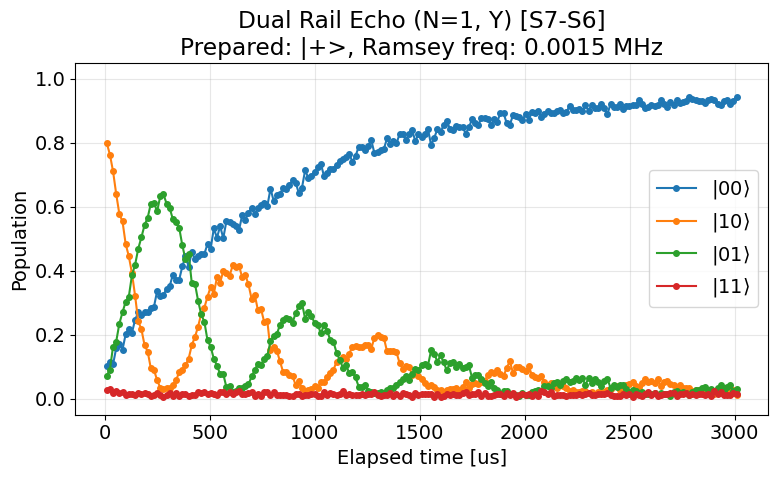

State + (raw), $p_1$: T2 = 3656 +/- 243 us, fit freq = 0.00148978 MHz
State + (raw), $p_0$: T2 = 3656 +/- 243 us, fit freq = 0.00148978 MHz


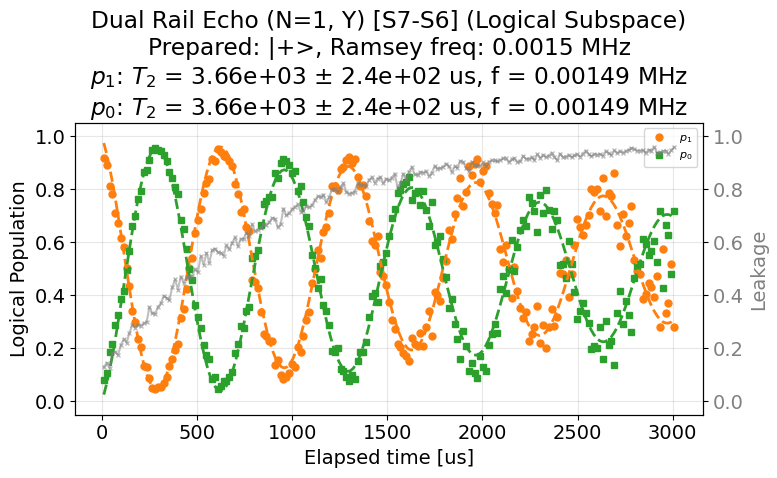

Running Dual Rail Echo Ramsey with n_checks=2
Running Dual Rail Ramsey for storage modes 7 and 6
Job submitted: JOB-20260224-00477 (queue position: 1)

[0.1s] Job JOB-20260224-00477: pending

[2.3s] Job JOB-20260224-00477: running
[WORKER] Loading DualRailRamseyExperiment from experiments.dual_rail.dual_rail_ramsey
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00477_DualRailRamseyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Distributed JP mode: 2 checks, n_wait_segments=4

=== Dual Rail Ramsey: state='+' ===
  Echo+JP symmetric: 1 before + 1 after echo, jp_phase=50.57 deg/check, correction = 0
Playing swap pulse for storage  7
Performing parity measurement for storage  7
needs a pretty long sync here due to the measurement
Playing swap pulse for storage  6
Performing parity measurement for storage  6
Playing swap back pulse for storage  6
rea

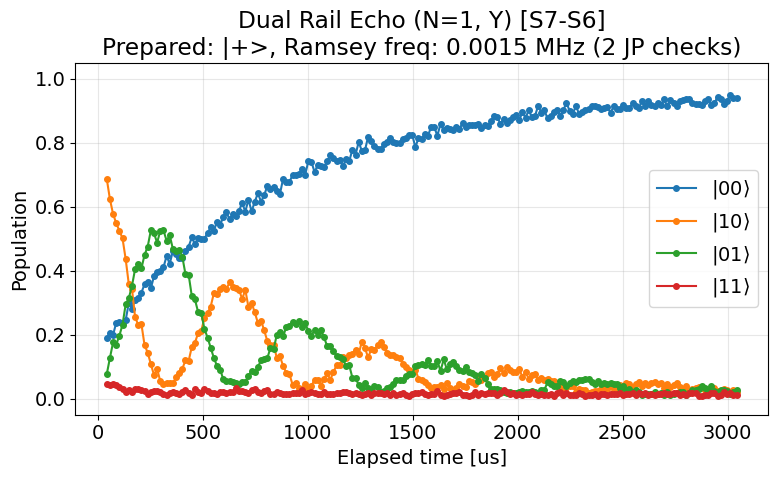

State + (raw), $p_1$: T2 = 3064 +/- 218 us, fit freq = 0.00148616 MHz
State + (raw), $p_0$: T2 = 3064 +/- 218 us, fit freq = 0.00148616 MHz


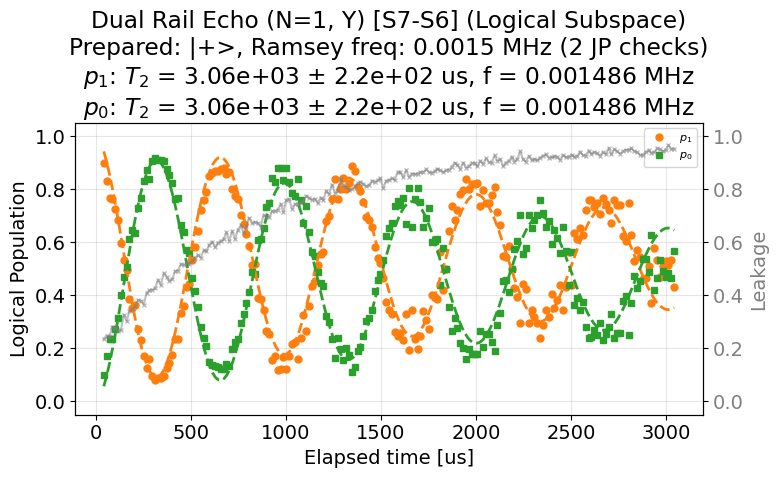

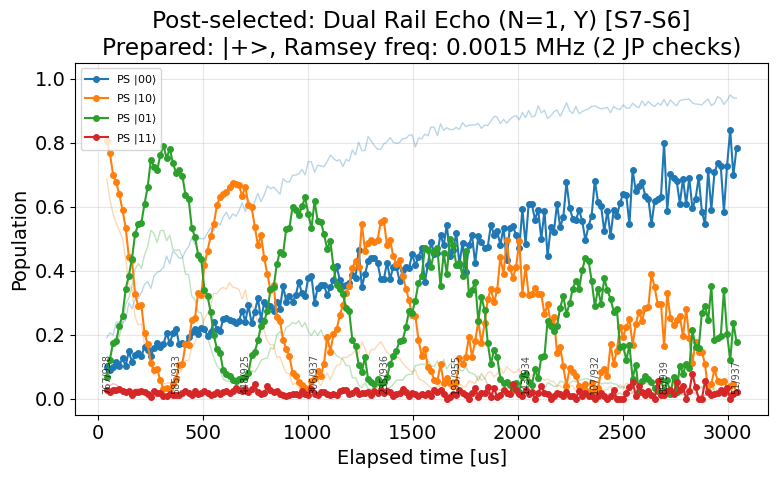

State + (ps_), $p_1$: T2 = 2.049e+04 +/- 5.92e+03 us, fit freq = 0.00149623 MHz
State + (ps_), $p_0$: T2 = 2.049e+04 +/- 5.92e+03 us, fit freq = 0.00149623 MHz


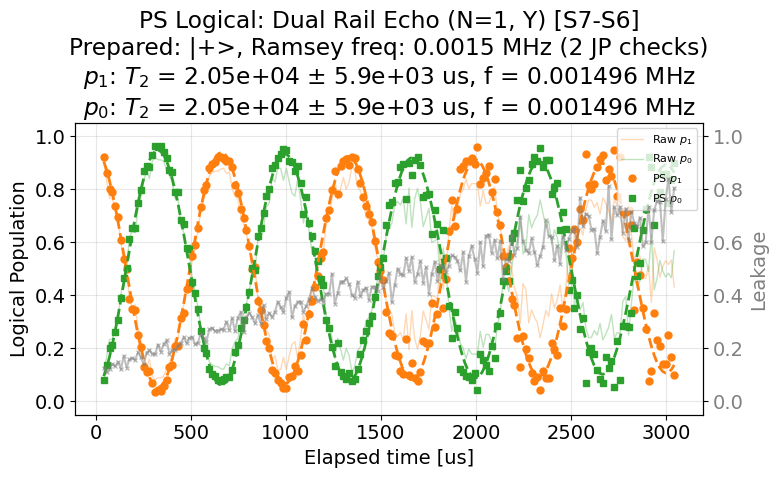

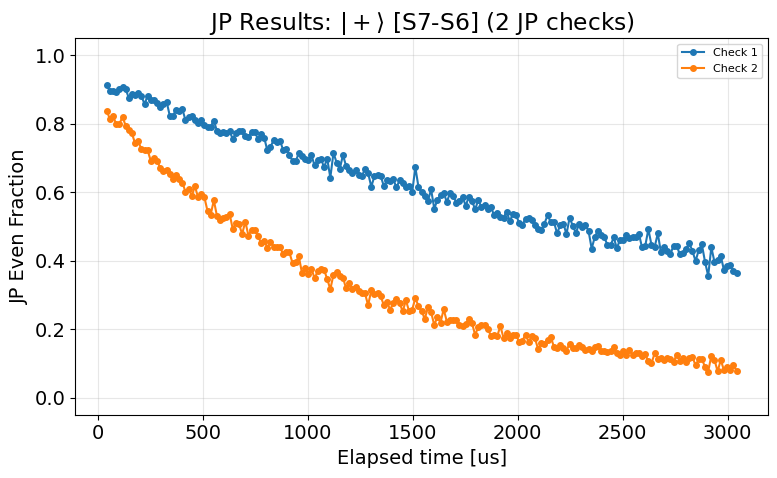

Running Dual Rail Echo Ramsey with n_checks=4
Running Dual Rail Ramsey for storage modes 7 and 6
Job submitted: JOB-20260224-00478 (queue position: 1)

[0.1s] Job JOB-20260224-00478: pending

[2.2s] Job JOB-20260224-00478: running
[WORKER] Loading DualRailRamseyExperiment from experiments.dual_rail.dual_rail_ramsey
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00478_DualRailRamseyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Distributed JP mode: 4 checks, n_wait_segments=6

=== Dual Rail Ramsey: state='+' ===
  Echo+JP symmetric: 2 before + 2 after echo, jp_phase=50.57 deg/check, correction = 0
Playing swap pulse for storage  7
Performing parity measurement for storage  7
needs a pretty long sync here due to the measurement
Playing swap pulse for storage  6
Performing parity measurement for storage  6
Playing swap back pulse for storage  6
rea

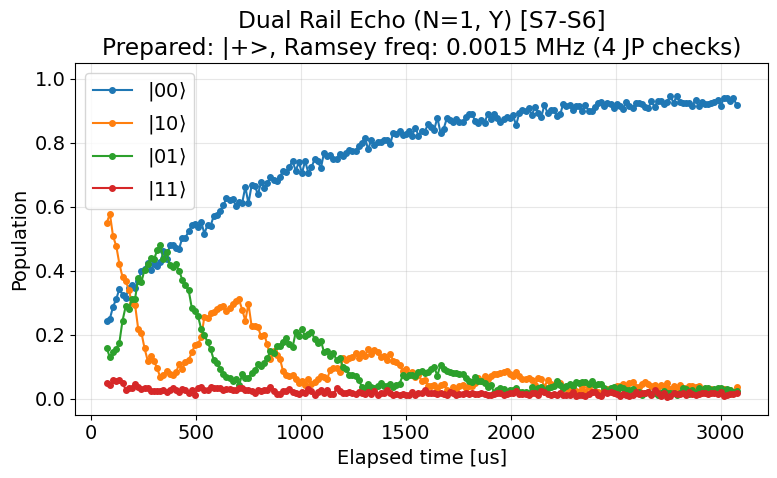

State + (raw), $p_1$: T2 = 2763 +/- 215 us, fit freq = 0.00149408 MHz
State + (raw), $p_0$: T2 = 2763 +/- 215 us, fit freq = 0.00149408 MHz


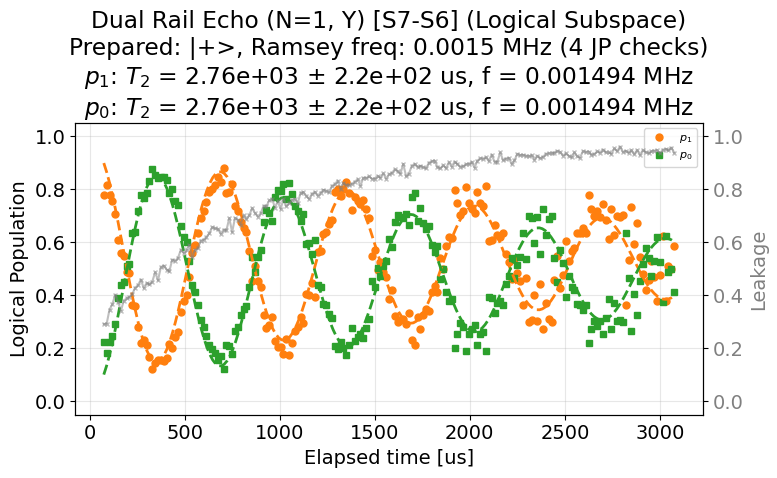

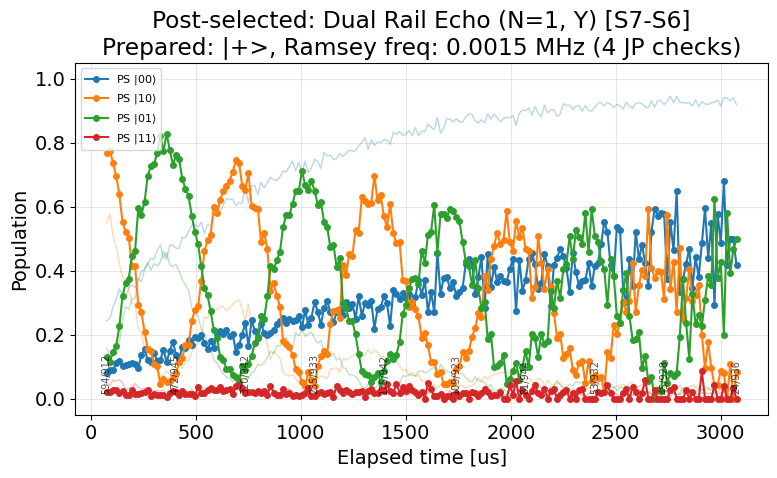

State + (ps_), $p_1$: T2 = 1.793e+04 +/- 5.45e+03 us, fit freq = 0.00149334 MHz
State + (ps_), $p_0$: T2 = 1.793e+04 +/- 5.45e+03 us, fit freq = 0.00149334 MHz


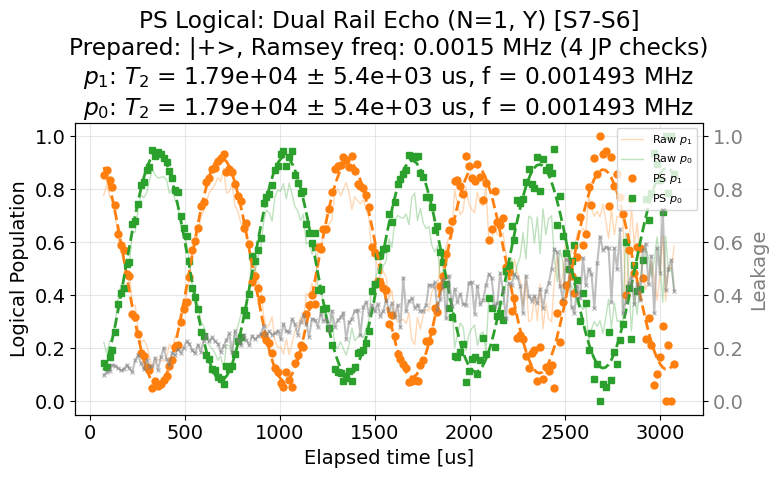

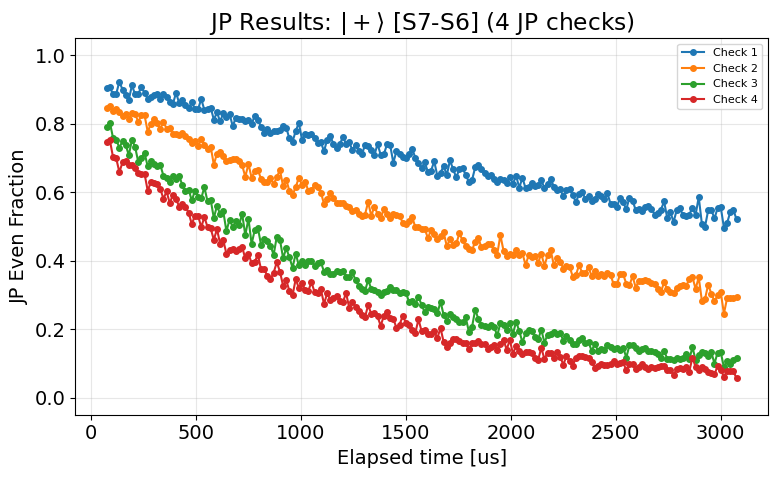

Running Dual Rail Echo Ramsey with n_checks=6
Running Dual Rail Ramsey for storage modes 7 and 6
Job submitted: JOB-20260224-00479 (queue position: 1)

[0.3s] Job JOB-20260224-00479: running
[WORKER] Loading DualRailRamseyExperiment from experiments.dual_rail.dual_rail_ramsey
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00479_DualRailRamseyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Distributed JP mode: 6 checks, n_wait_segments=8

=== Dual Rail Ramsey: state='+' ===
  Echo+JP symmetric: 3 before + 3 after echo, jp_phase=50.57 deg/check, correction = 0
Playing swap pulse for storage  7
Performing parity measurement for storage  7
needs a pretty long sync here due to the measurement
Playing swap pulse for storage  6
Performing parity measurement for storage  6
Playing swap back pulse for storage  6
read num 12
Phase tracking ON: AC Stark rat

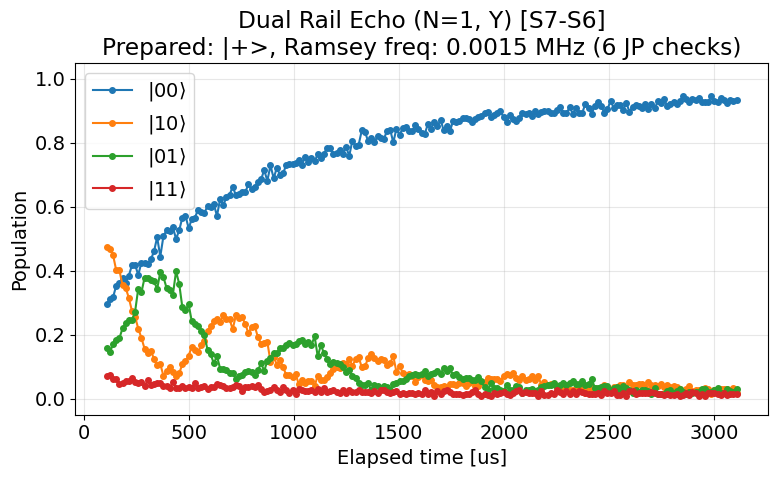

State + (raw), $p_1$: T2 = 2517 +/- 223 us, fit freq = 0.00149768 MHz
State + (raw), $p_0$: T2 = 2517 +/- 223 us, fit freq = 0.00149768 MHz


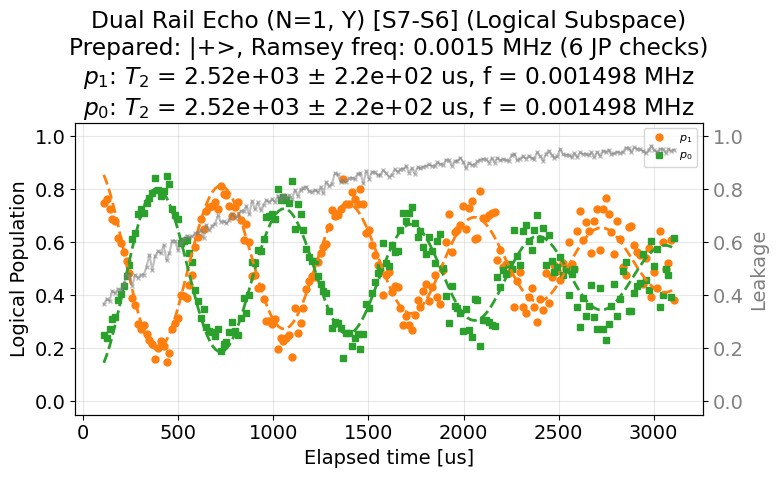

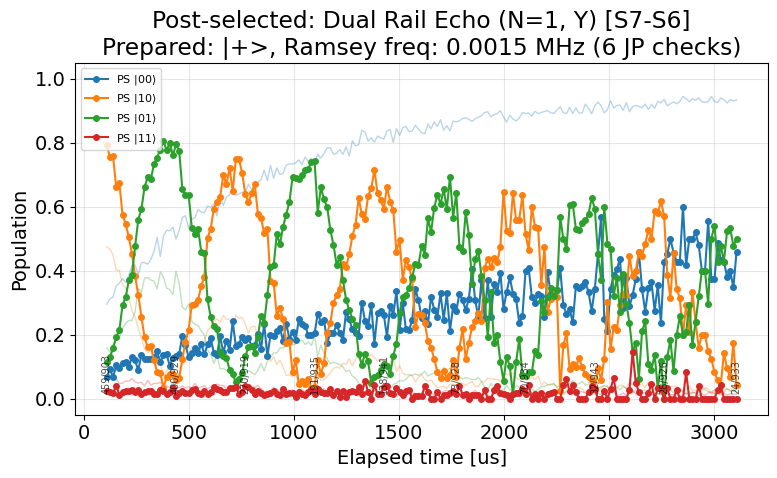

State + (ps_), $p_1$: T2 = 1.319e+04 +/- 3.07e+03 us, fit freq = 0.0015029 MHz
State + (ps_), $p_0$: T2 = 1.319e+04 +/- 3.07e+03 us, fit freq = 0.0015029 MHz


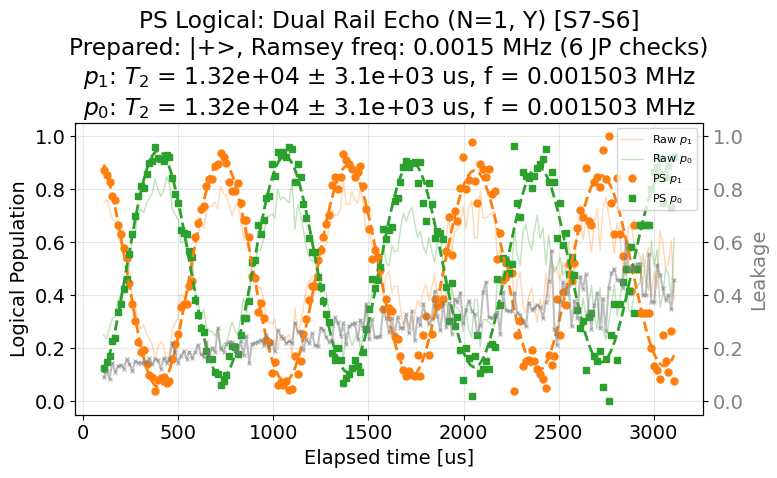

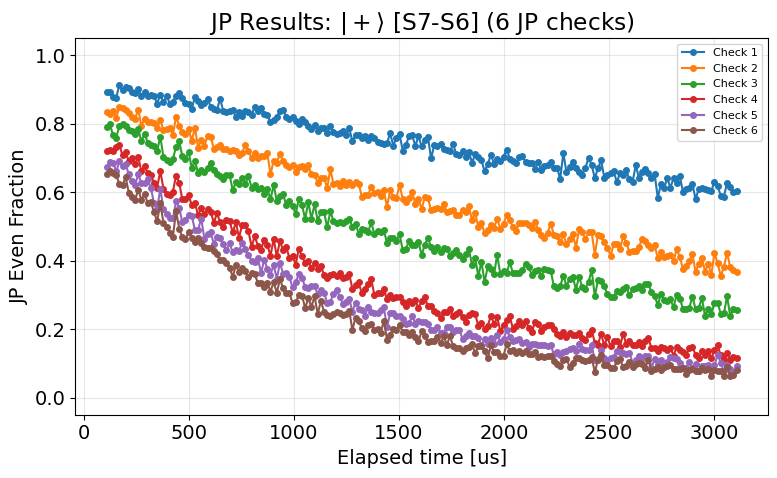

Running Dual Rail Echo Ramsey with n_checks=8
Running Dual Rail Ramsey for storage modes 7 and 6
Job submitted: JOB-20260224-00480 (queue position: 1)

[0.1s] Job JOB-20260224-00480: pending

[2.1s] Job JOB-20260224-00480: running
[WORKER] Loading DualRailRamseyExperiment from experiments.dual_rail.dual_rail_ramsey
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00480_DualRailRamseyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Distributed JP mode: 8 checks, n_wait_segments=10

=== Dual Rail Ramsey: state='+' ===
  Echo+JP symmetric: 4 before + 4 after echo, jp_phase=50.57 deg/check, correction = 0
Playing swap pulse for storage  7
Performing parity measurement for storage  7
needs a pretty long sync here due to the measurement
Playing swap pulse for storage  6
Performing parity measurement for storage  6
Playing swap back pulse for storage  6
re

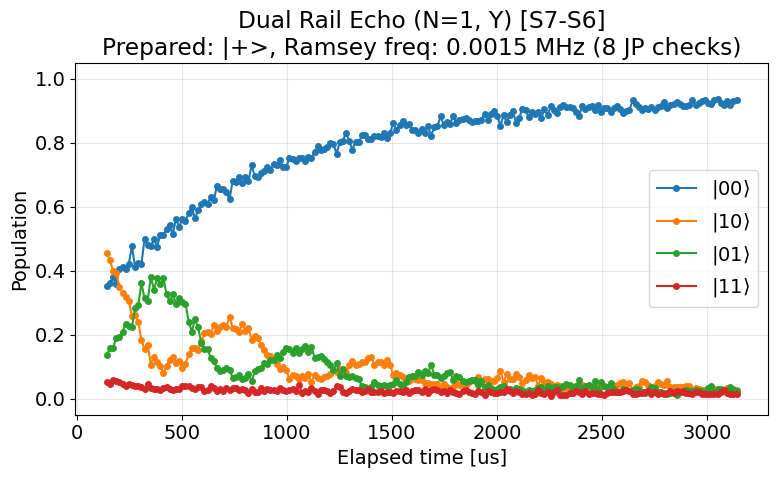

State + (raw), $p_1$: T2 = 2446 +/- 238 us, fit freq = 0.00149528 MHz
State + (raw), $p_0$: T2 = 2446 +/- 238 us, fit freq = 0.00149528 MHz


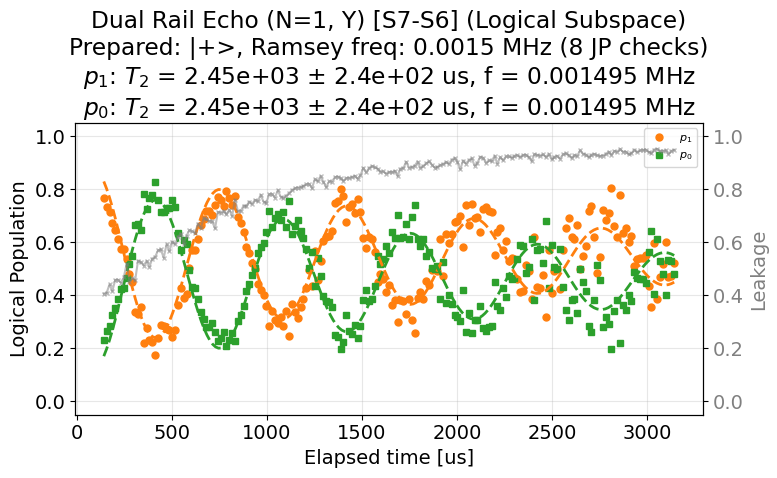

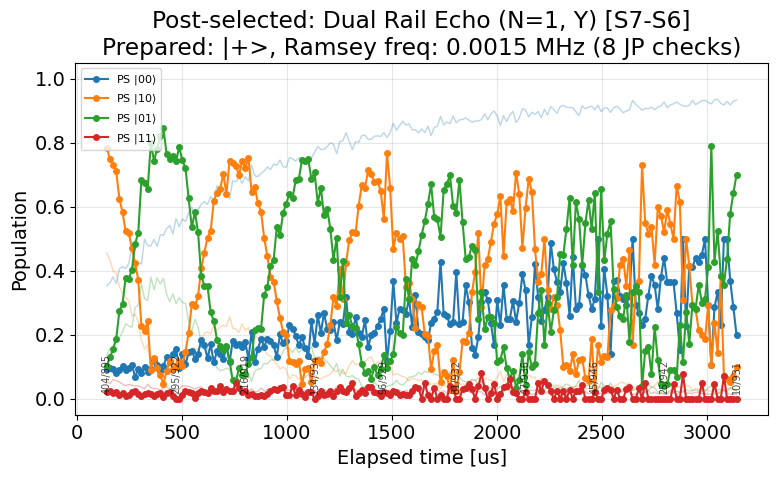

State + (ps_), $p_1$: T2 = 1.23e+04 +/- 3.42e+03 us, fit freq = 0.00149223 MHz
State + (ps_), $p_0$: T2 = 1.23e+04 +/- 3.42e+03 us, fit freq = 0.00149223 MHz


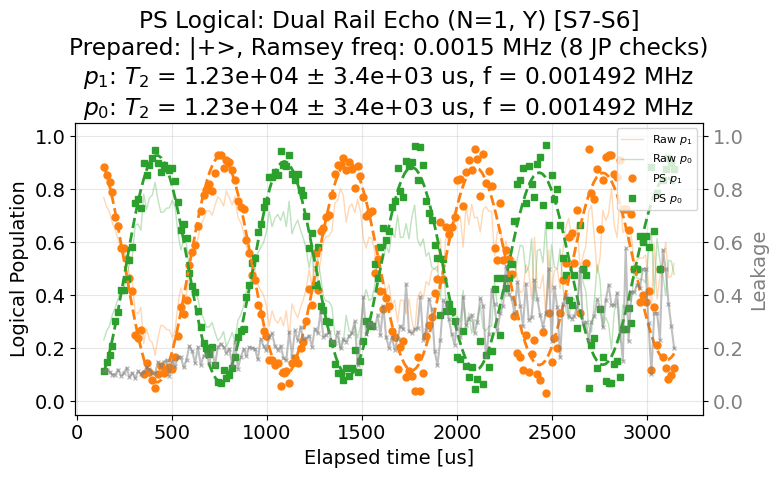

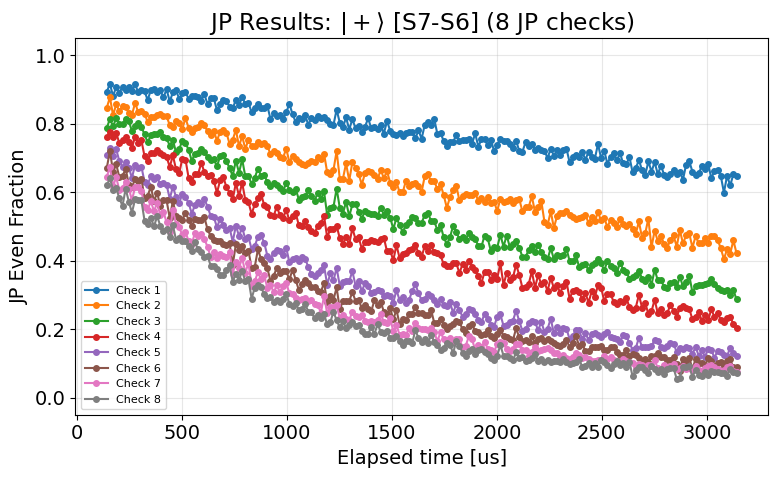

Running Dual Rail Echo Ramsey with n_checks=10
Running Dual Rail Ramsey for storage modes 7 and 6
Job submitted: JOB-20260224-00481 (queue position: 1)

[0.2s] Job JOB-20260224-00481: pending

[2.2s] Job JOB-20260224-00481: running
[WORKER] Loading DualRailRamseyExperiment from experiments.dual_rail.dual_rail_ramsey
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00481_DualRailRamseyExperiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Distributed JP mode: 10 checks, n_wait_segments=12

=== Dual Rail Ramsey: state='+' ===
  Echo+JP symmetric: 5 before + 5 after echo, jp_phase=50.57 deg/check, correction = 0
Playing swap pulse for storage  7
Performing parity measurement for storage  7
needs a pretty long sync here due to the measurement
Playing swap pulse for storage  6
Performing parity measurement for storage  6
Playing swap back pulse for storage  6


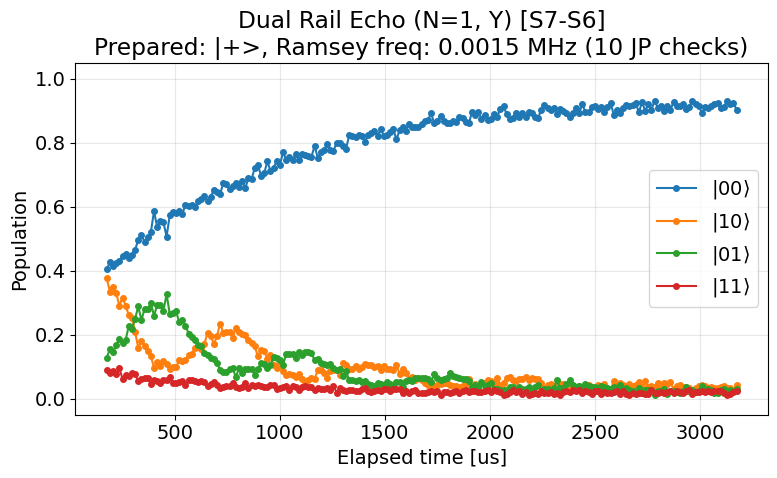

State + (raw), $p_1$: T2 = 1995 +/- 188 us, fit freq = 0.00148381 MHz
State + (raw), $p_0$: T2 = 1995 +/- 188 us, fit freq = 0.00148381 MHz


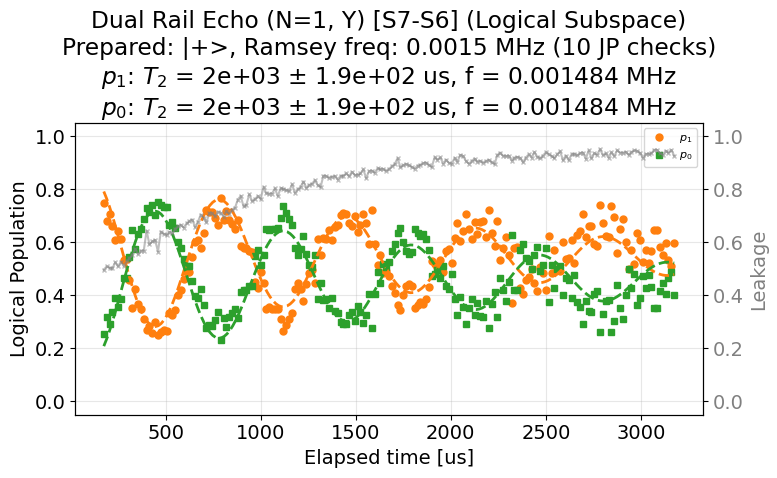

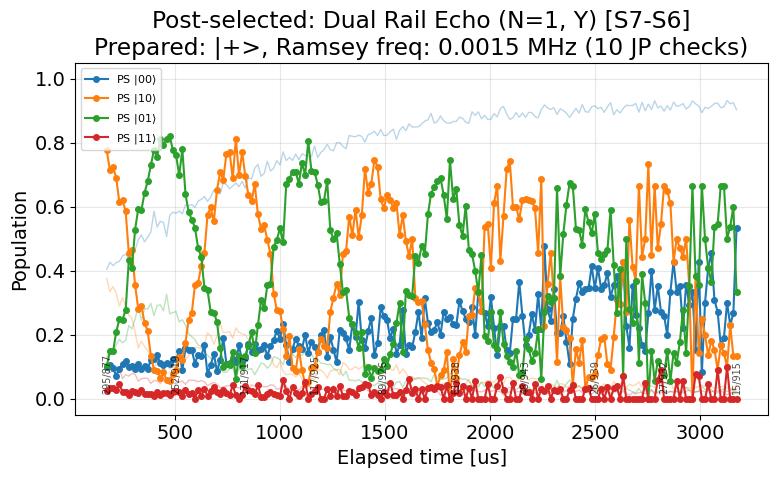

State + (ps_), $p_1$: T2 = 1.191e+04 +/- 3.59e+03 us, fit freq = 0.00149915 MHz
State + (ps_), $p_0$: T2 = 1.191e+04 +/- 3.59e+03 us, fit freq = 0.00149915 MHz


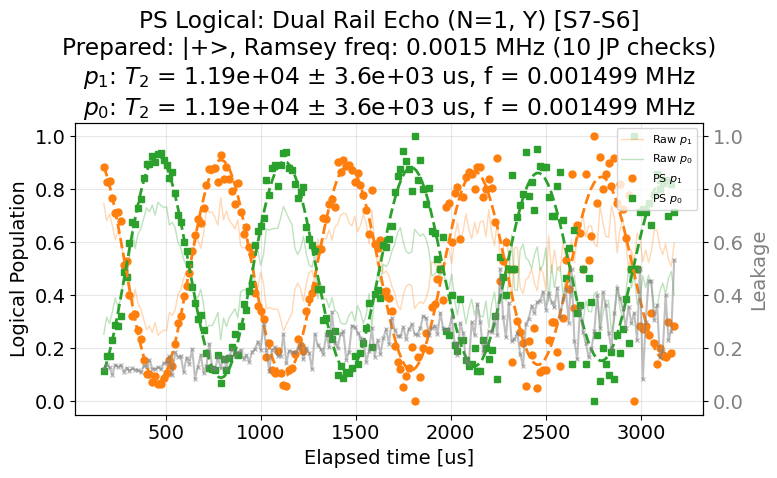

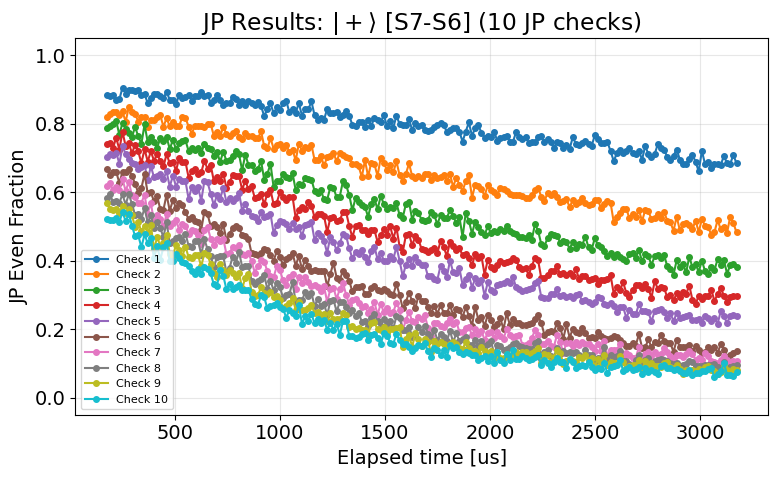

In [24]:
expt = 201
reps = 1000
step = 15
storage_1 = [7]
storage_2 = [6]
n_checks_list = [0, 2, 4, 6, 8, 10]
# n_checks_list = [6]

# single_shot = single_shot_runner.execute(
#         go_kwargs=dict(analyze=False, display=False),
#         check_f=False,
#         relax_delay=2500,
#         gate_based=False,
#         # **active_reset_dict,
#     )

for n_checks in n_checks_list:
    print(f"Running Dual Rail Echo Ramsey with n_checks={n_checks}")
    for s1, s2 in zip(storage_1, storage_2):
        print(f"Running Dual Rail Ramsey for storage modes {s1} and {s2}")

        dual_rail_ramsey_expt = dual_rail_ramsey_runner.execute(
            state_start=['+'],
            storage_swap=s1,
            storage_parity=s2,
            ramsey_freq=0.0015,
            start=0.0001,
            step=step,
            expts=expt,
            reps=reps,
            n_checks=n_checks,
            phase_tracking=True,
            echoes=1,
            go_kwargs=dict(analyze=False, display=False),
            **active_reset_dict,
            state_prep_postselect=True
        )

        if USE_QUEUE:
            dual_rail_ramsey_expt.analyze(fit=True)
            dual_rail_ramsey_expt.display(fit=True, n_iq_panels=10, show_iq=False)


## T2 storages modes 

In [ ]:
# ============================================
# Cavity Mode T2 (Ramsey / Echo) - per-mode coherence
# ============================================

t2_cavity_mode_defaults = AttrDict(dict(
    start=0.01,
    step=0.02 * 50,
    expts=200,
    ramsey_freq=-5.55,
    reps=250,
    rounds=1,
    qubits=[0],
    mode='storage',          # 'storage', 'manipulate', or 'coupler'
    storage_mode_idx=1,      # for storage mode
    man_mode_no=1,           # manipulate mode to go through (for storage)
    man_mode_idx=1,          # for manipulate mode
    phase_on_flux=True,
    echoes=0,                # 0 = Ramsey, >0 = Echo
    parity_meas=True,
    active_reset=False,
    prepulse=False,
    postpulse=False,
    gate_based=True,
))


t2_cavity_mode_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.t2_cavity_mode.CavityModeRamseyExperiment,
    default_expt_cfg=t2_cavity_mode_defaults,
    job_client=client,
    use_queue=USE_QUEUE,
)


In [ ]:
storage_modes = [1, 3, 2, 4, 6, 7]

for s in storage_modes:
    print(f"Running Cavity Mode Ramsey for storage mode {s}")
    t2_mode = t2_cavity_mode_runner.execute(
        mode='storage',
        storage_mode_idx=s,
        man_mode_no=1,
        ramsey_freq=-5.55,
        go_kwargs=dict(analyze=True, display=True),
        **active_reset_dict,
    )

    if USE_QUEUE:
        t2_mode.analyze()
        t2_mode.display()


## T1 dual rail

In [12]:
# ============================================
# Dual Rail T1 Experiment
# ============================================

# 1. Define defaults
dual_rail_t1_defaults = AttrDict(dict(
    # Sweep
    start=0,                 # total time sweep start [us]
    step=60,                 # total time sweep step [us]
    expts=100,               # number of time points
    # Averaging
    reps=1000,
    rounds=1,
    # Joint parity checks (0 = pure T1, 1 = one check at Tf/2, etc.)
    n_checks=0,
    # Storage modes for dual rail
    storage_swap=1,
    storage_parity=3,
    manipulate=1,
    # State preparation
    state_start='10',
    # Parity options
    parity_fast=False,
    measure_parity=True,
    # Reset options
    active_reset=False,
    reset_before_dual_rail=False,
    reset_after_dual_rail=False,
    # Qubit selection
    qubits=[0],
    relax_delay=10000,
))


# 2. Optional postprocessor
def dual_rail_t1_postproc(station, expt):
    """Post-process dual rail T1 results."""
    expt.analyze(post_select=True)
    return None


# 3. Create the runner
dual_rail_t1_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.DualRailT1Experiment,
    default_expt_cfg=dual_rail_t1_defaults,
    postprocessor=dual_rail_t1_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)


Testing Dual Rail T1 with n_checks=6
Testing Dual Rail T1 for storage modes: 4 and 2
Job submitted: JOB-20260224-00483 (queue position: 1)

[0.1s] Job JOB-20260224-00483: pending

[2.1s] Job JOB-20260224-00483: running
[WORKER] Loading DualRailT1Experiment from experiments.dual_rail.dual_rail_t1
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00483_DualRailT1Experiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Dual Rail T1: 10 time points from 0 to 2000.0 us, step=222.22222222222223 us, 6 JP checks
  Distributed equal waits: 7 segments
States:   0%|                                            | 0/1 [00:00<?, ?it/s]
=== Running state_start='10' ===
prepulse seq: [['multiphoton', 'g0-e0', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0], ['multiphoton', 'f0-g1', 'pi', 0], ['storage', 'M1-S4', 'pi', 0]]
Playing swap pulse for storage  4
Performing parity measur

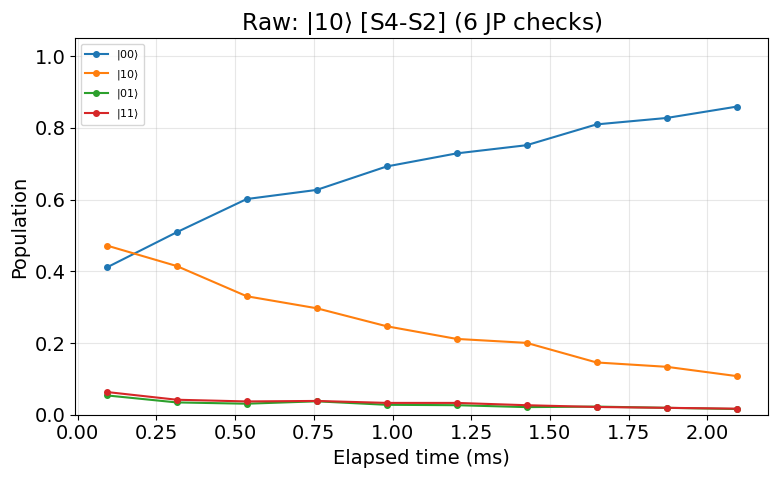

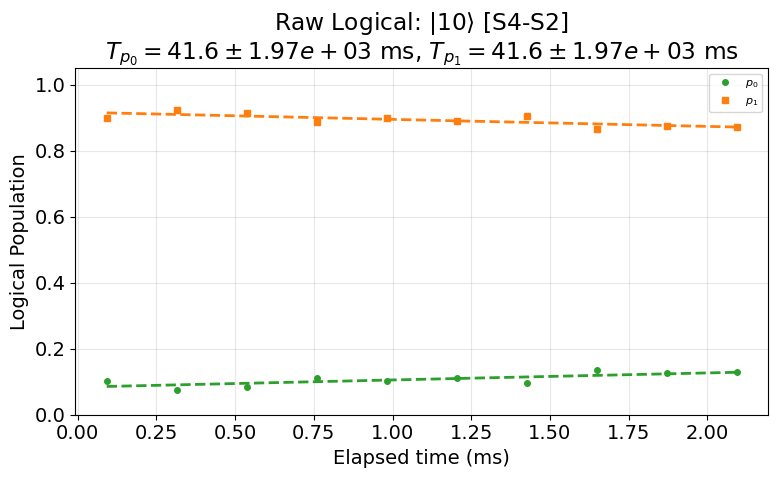

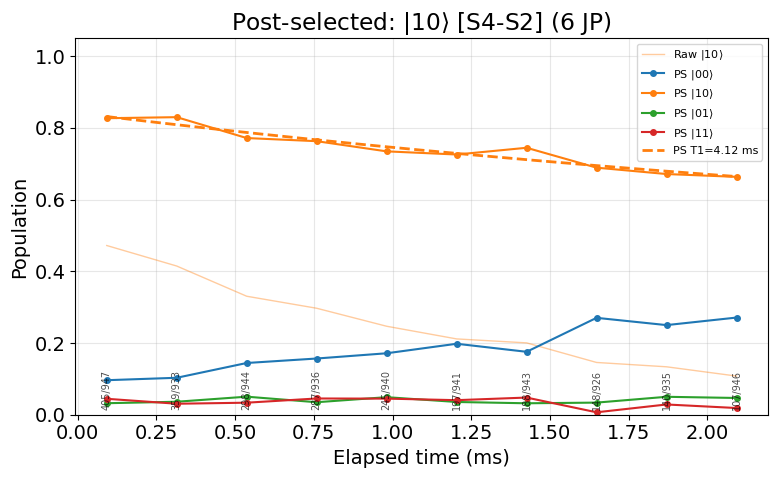

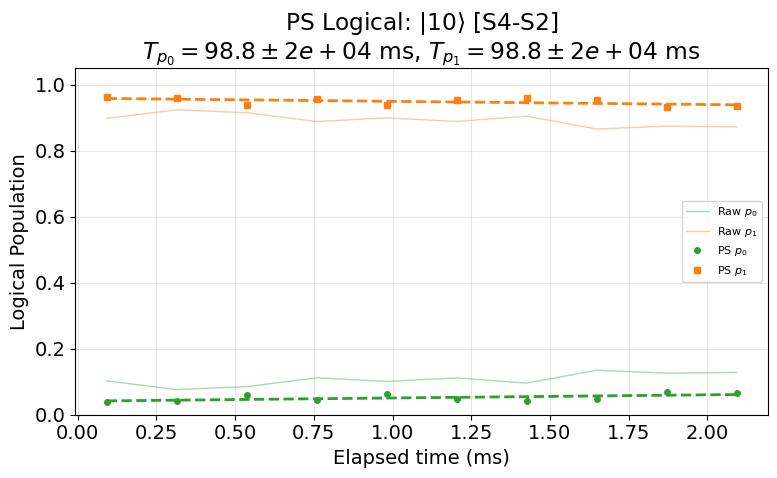

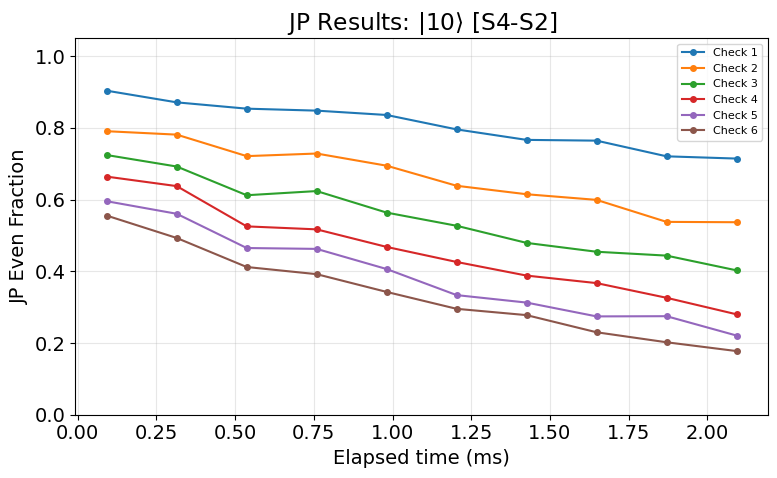

In [ ]:

# storage_parity = [3, 2, 6]
# storage_swap = [1, 4, 7]

storage_parity = [2, 3, 6]
storage_swap = [4, 1, 7]
# final_time = 1000
final_time = 2000
expts = 201
# reps = 2500
reps = 1500
step = final_time/(expts-1)

n_checks_list = [0, 2, 4, 8, 12, 16]
n_checks_list = [6]
for n_checks in n_checks_list:
    print(f"Testing Dual Rail T1 with n_checks={n_checks}")
    for s1, s2 in zip(storage_swap, storage_parity):
        print(f"Testing Dual Rail T1 for storage modes: {s1} and {s2}")

        # 4. Execute - Pure T1 (no parity checks)
        dual_rail_t1_expt = dual_rail_t1_runner.execute(
            # state_start=['10', '01'],
            state_start=['10'],
            storage_swap=s1,
            storage_parity=s2,
            n_checks=n_checks,
            start=0,
            step=step,
            expts=expts,
            reps=reps,
            go_kwargs=dict(analyze=False, display=False),
            **active_reset_dict,
            state_prep_postselect=True
        )

        if USE_QUEUE:
            dual_rail_t1_expt.analyze(post_select=True)
            dual_rail_t1_expt.display()


# expt = 201
# reps = 2500
# step = 15
# storage_1 = [7, 4, 3]
# storage_2 = [6, 2, 1]

# for s1, s2 in zip(storage_1, storage_2):
#     print(f"Running Dual Rail Ramsey for storage modes {s1} and {s2}")

#     dual_rail_ramsey_expt = dual_rail_ramsey_runner.execute(
#         state_start=['+'],
#         storage_swap=s1,
#         storage_parity=s2,
#         ramsey_freq=0.0015,
#         start=0.0001,
#         step=step,
#         expts=expt,
#         reps=reps,
#         n_checks=10,
#         phase_tracking=True,
#         echoes=1,
#         go_kwargs=dict(analyze=False, display=False),
#         **active_reset_dict,
#         state_prep_postselect=True
#     )

#     if USE_QUEUE:
#         dual_rail_ramsey_expt.analyze(fit=True)
#         dual_rail_ramsey_expt.display(fit=True, n_iq_panels=10, show_iq=False)


Fit failed for state |10> (raw): Initial guess is outside of provided bounds
State |10> (post-selected): T1 = 5.973 +/- 30.47 ms

--- Diagnostic: state='10', n_checks=6 ---
 pt  time_us  raw_ct  ps_ct ps_surv%  jp_avg  raw10  raw01   ps10   ps01  jp0 jp1 jp2 jp3 jp4 jp5
  0      0.0     470    208    44.3%   0.711  0.474  0.057  0.832  0.034  0.89 0.79 0.69 0.67 0.63 0.61
  1     15.2     467    193    41.3%   0.702  0.448  0.064  0.855  0.047  0.87 0.81 0.73 0.66 0.60 0.54 <--
  2     30.3     475    183    38.5%   0.689  0.434  0.063  0.847  0.044  0.88 0.77 0.72 0.63 0.60 0.54 <--
  3     45.5     459    180    39.2%   0.672  0.407  0.057  0.811  0.044  0.84 0.76 0.71 0.64 0.56 0.52
  4     60.6     468    183    39.1%   0.683  0.453  0.047  0.880  0.000  0.88 0.77 0.69 0.64 0.58 0.53
  5     75.8     472    172    36.4%   0.677  0.383  0.078  0.831  0.029  0.88 0.80 0.71 0.61 0.55 0.50 <--
  6     90.9     469    177    37.7%   0.661  0.405  0.051  0.819  0.045  0.89 0.76 0.65 0.61

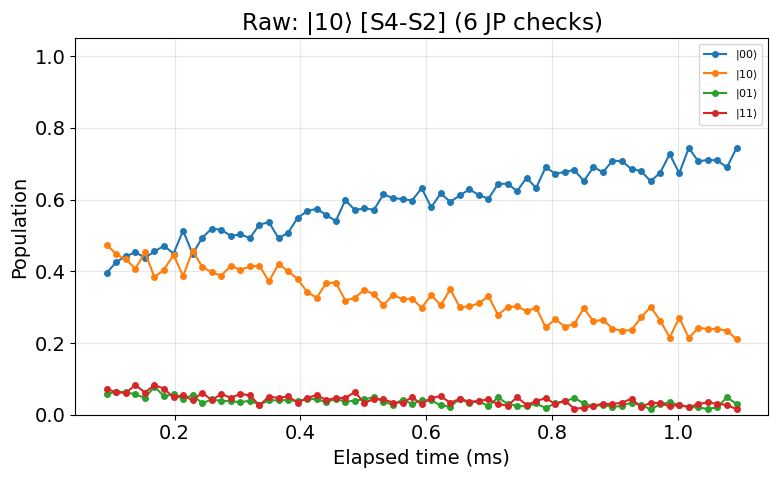

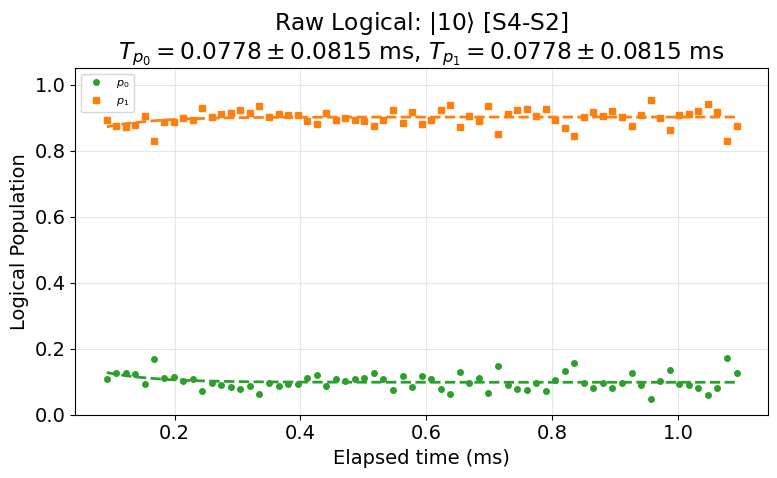

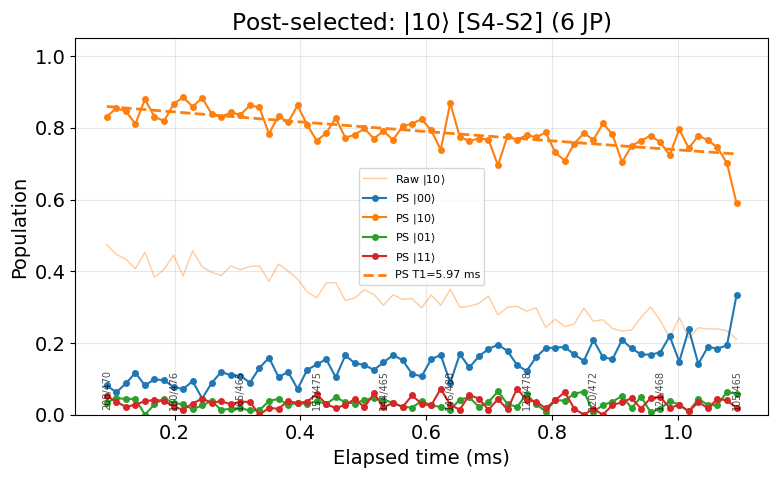

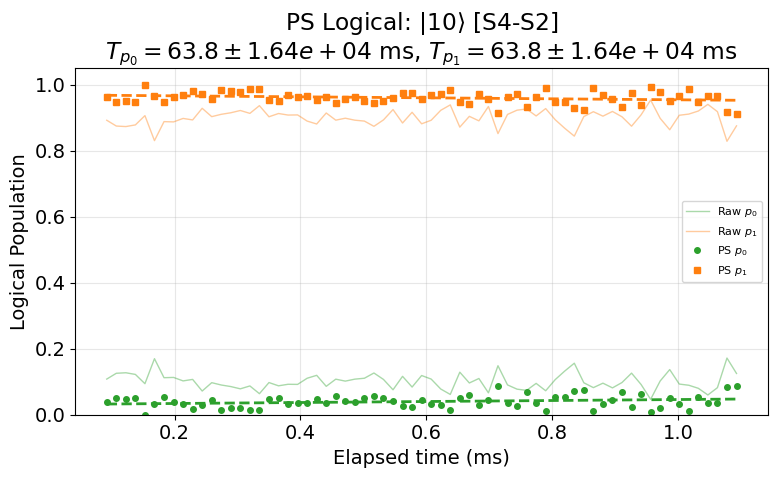

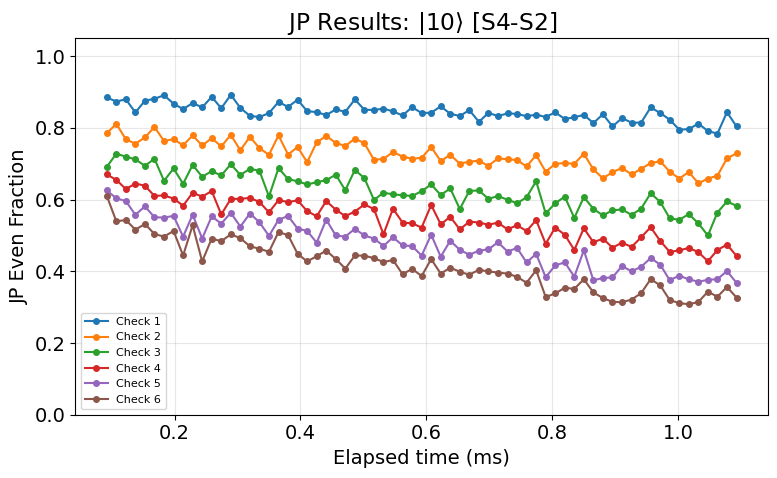

In [21]:

if USE_QUEUE:
    dual_rail_t1_expt.analyze(post_select=True)
    dual_rail_t1_expt.display()


Testing Dual Rail T1 with n_checks=0
Job submitted: JOB-20260223-00165 (queue position: 1)

[0.2s] Job JOB-20260223-00165: pending

[2.5s] Job JOB-20260223-00165: running
[WORKER] Loading DualRailT1Experiment from experiments.dual_rail.dual_rail_t1
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260223-00165_DualRailT1Experiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Dual Rail T1: 11 time points from 0 to 1000.0 us, step=100.0 us, 0 JP checks
States:   0%|                                            | 0/1 [00:00<?, ?it/s]
=== Running state_start='10' ===
  Segment 0: 11 pts, 0 JP, times [0.00, 1000.00] us, wait_start=0.00 us
prepulse seq: [['multiphoton', 'g0-e0', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0], ['multiphoton', 'f0-g1', 'pi', 0], ['storage', 'M1-S3', 'pi', 0]]
Playing swap pulse for storage  3
Performing parity measurement for storage  3
needs 

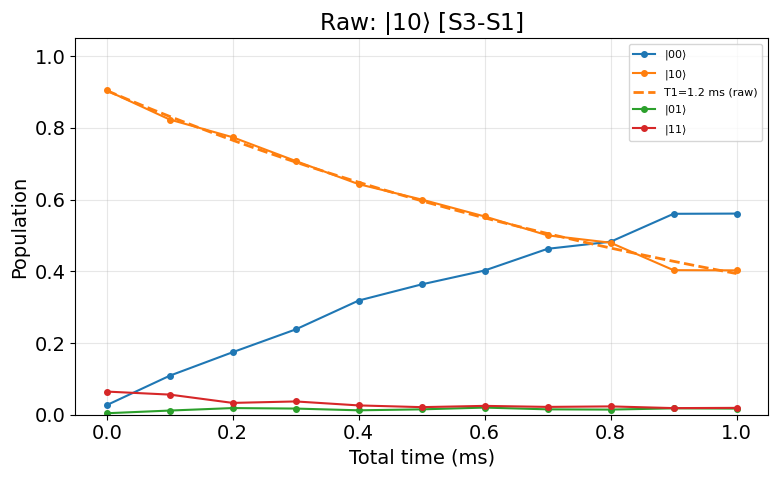

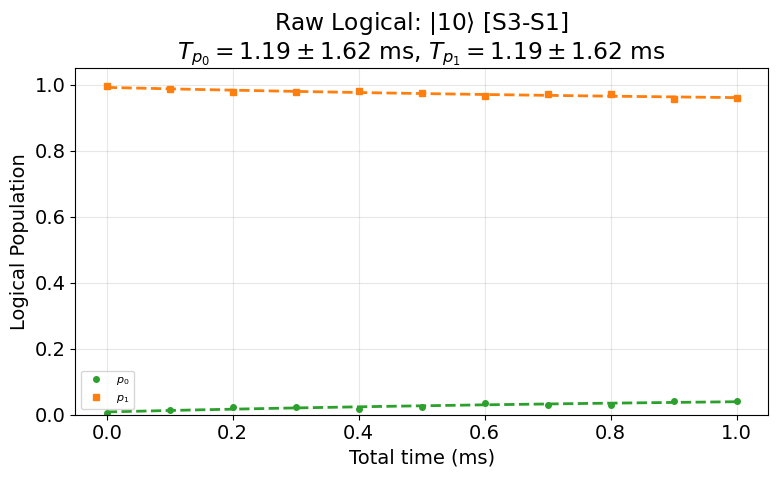

Testing Dual Rail T1 with n_checks=4
Job submitted: JOB-20260223-00166 (queue position: 1)

[0.1s] Job JOB-20260223-00166: pending

[2.2s] Job JOB-20260223-00166: running
[WORKER] Loading DualRailT1Experiment from experiments.dual_rail.dual_rail_t1
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260223-00166_DualRailT1Experiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Dual Rail T1: 11 time points from 0 to 1000.0 us, step=100.0 us, 4 JP checks
  Check times: ['200.00', '400.00', '600.00', '800.00'] us
States:   0%|                                            | 0/1 [00:00<?, ?it/s]
=== Running state_start='10' ===
  Segment 0: 2 pts, 0 JP, times [0.00, 100.00] us, wait_start=0.00 us
prepulse seq: [['multiphoton', 'g0-e0', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0], ['multiphoton', 'f0-g1', 'pi', 0], ['storage', 'M1-S3', 'pi', 0]]
Playing swap pulse for stora

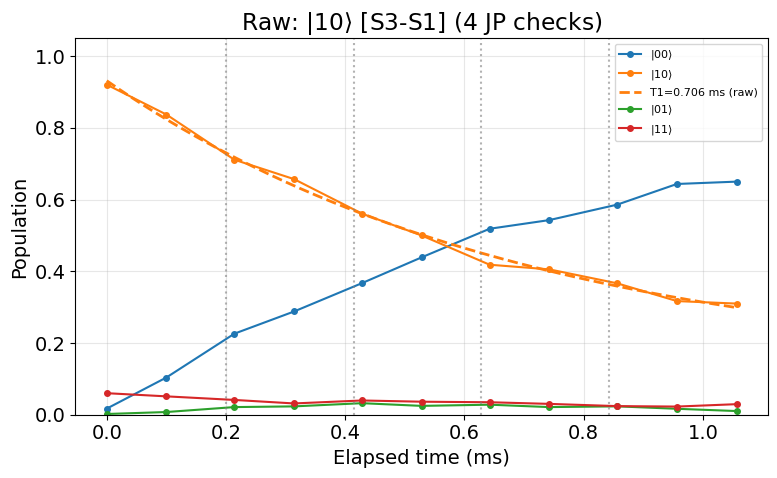

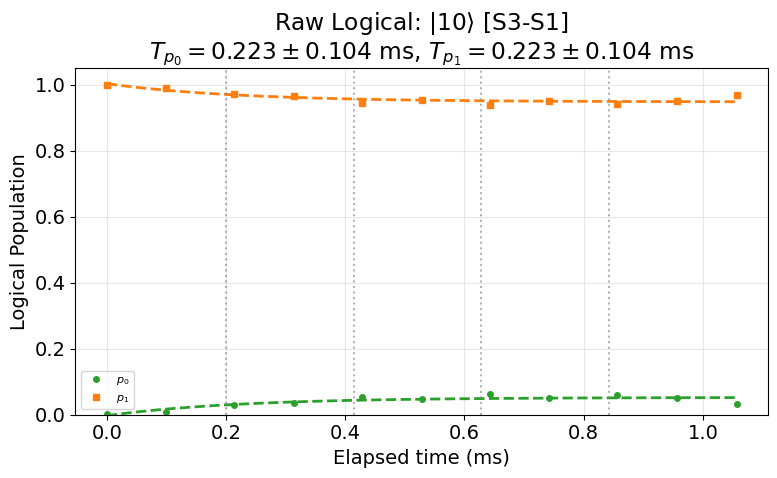

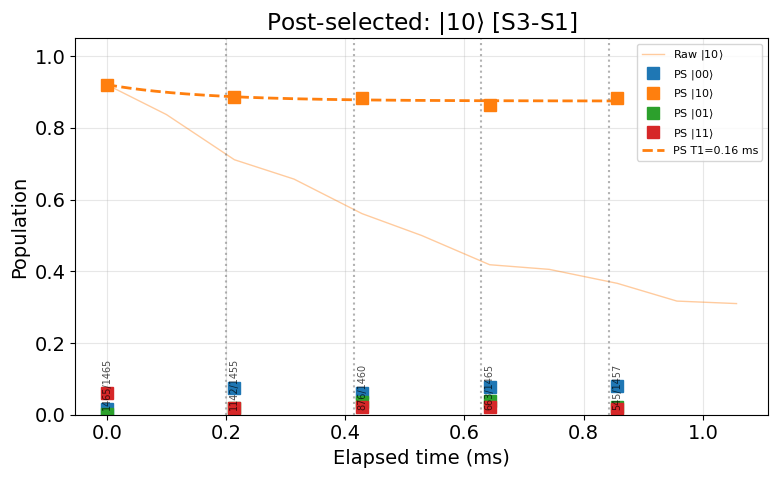

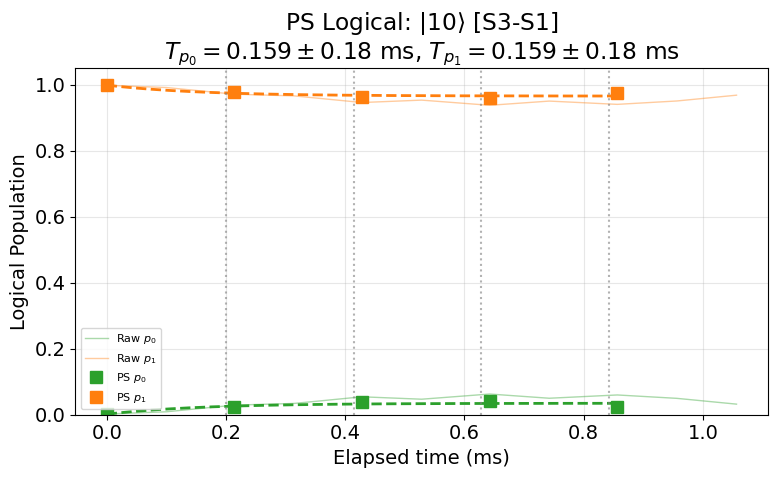

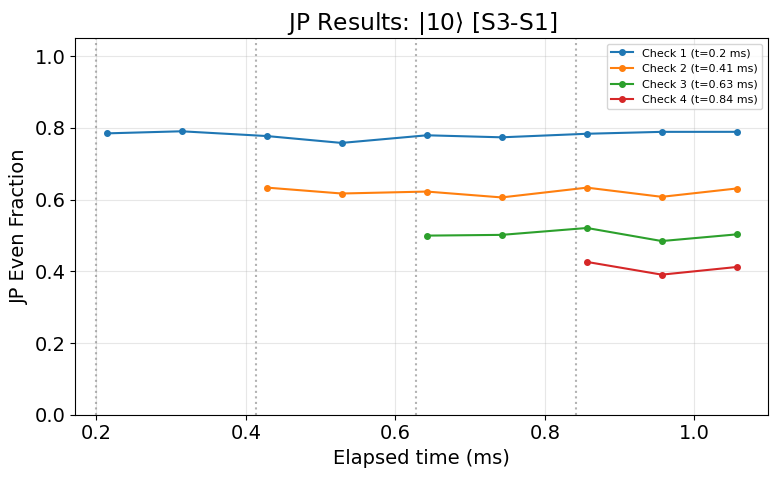

Testing Dual Rail T1 with n_checks=8
Job submitted: JOB-20260223-00168 (queue position: 1)

[0.1s] Job JOB-20260223-00168: pending

[61.4s] Job JOB-20260223-00168: running
[WORKER] Loading DualRailT1Experiment from experiments.dual_rail.dual_rail_t1
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260223-00168_DualRailT1Experiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Dual Rail T1: 11 time points from 0 to 1000.0 us, step=100.0 us, 8 JP checks
  Check times: ['111.11', '222.22', '333.33', '444.44', '555.56', '666.67', '777.78', '888.89'] us
States:   0%|                                            | 0/1 [00:00<?, ?it/s]
=== Running state_start='10' ===
  Segment 0: 2 pts, 0 JP, times [0.00, 100.00] us, wait_start=0.00 us
prepulse seq: [['multiphoton', 'g0-e0', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0], ['multiphoton', 'f0-g1', 'pi', 0], ['storage', 'M1-S3

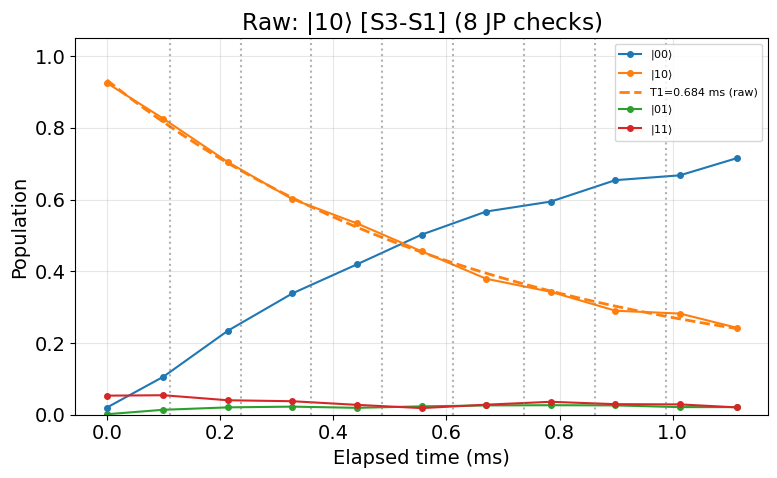

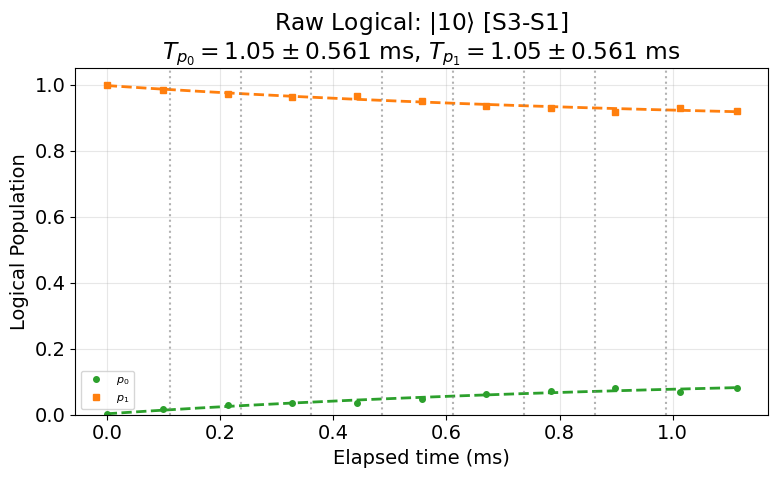

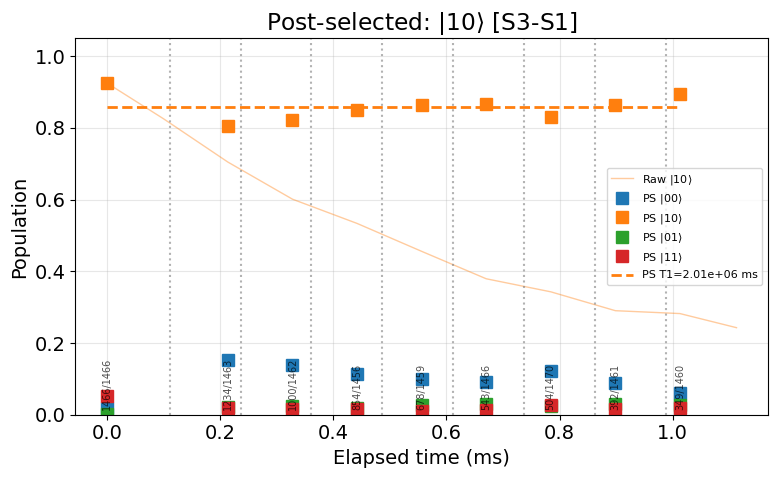

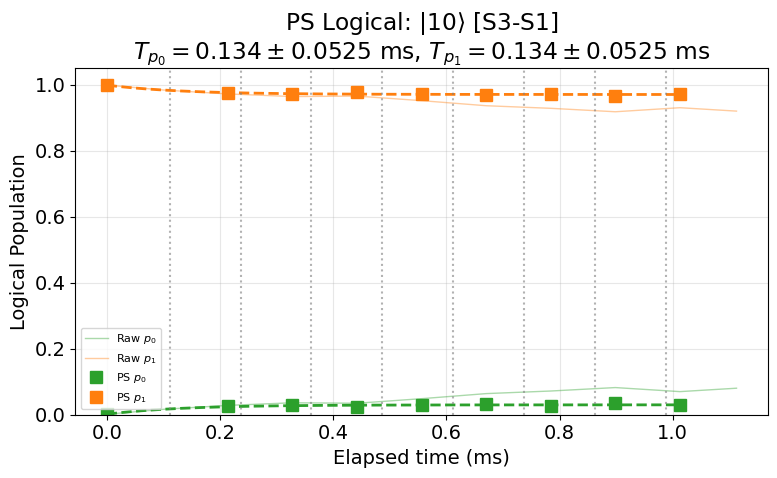

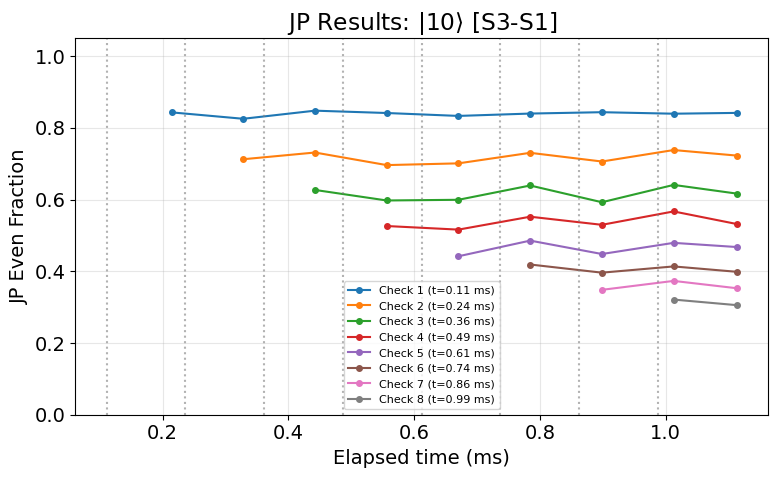

In [ ]:
final_time = 1000
expts = 11 
step = final_time/(expts-1)
n_checks_list = np.arange(0, 10, 2)

for n_checks in n_checks_list:
    print(f"Testing Dual Rail T1 with n_checks={n_checks}")

    # 5. Execute - T1 with 1 parity check at Tf/2
    dual_rail_t1_jp1 = dual_rail_t1_runner.execute(
        state_start=['10'],
        storage_swap=3,
        storage_parity=1,
        n_checks=n_checks,
        start=0,
        step=step,
        expts=expts,
        reps=1500,
        go_kwargs=dict(analyze=False, display=False),
        **active_reset_dict,
    )

    if USE_QUEUE:
        dual_rail_t1_jp1.analyze(post_select=True)
        dual_rail_t1_jp1.display()


<unknown>:712: SyntaxWarning: invalid escape sequence '\p'
<unknown>:712: SyntaxWarning: invalid escape sequence '\p'


State |10> (raw): T1 = 0.7489 +/- 0.07466 ms
State |10> (post-selected): T1 = 6.791 +/- 200.4 ms
State |01> (raw): T1 = 0.9871 +/- 0.1343 ms
State |01> (post-selected): T1 = 8.905 +/- 139.3 ms


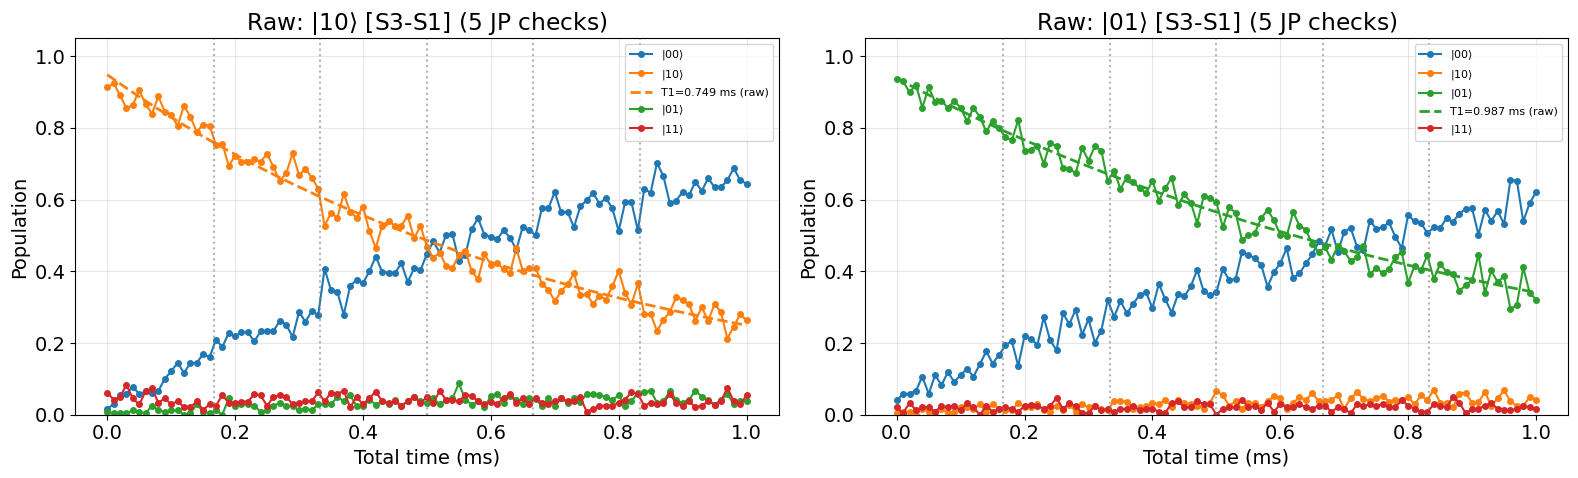

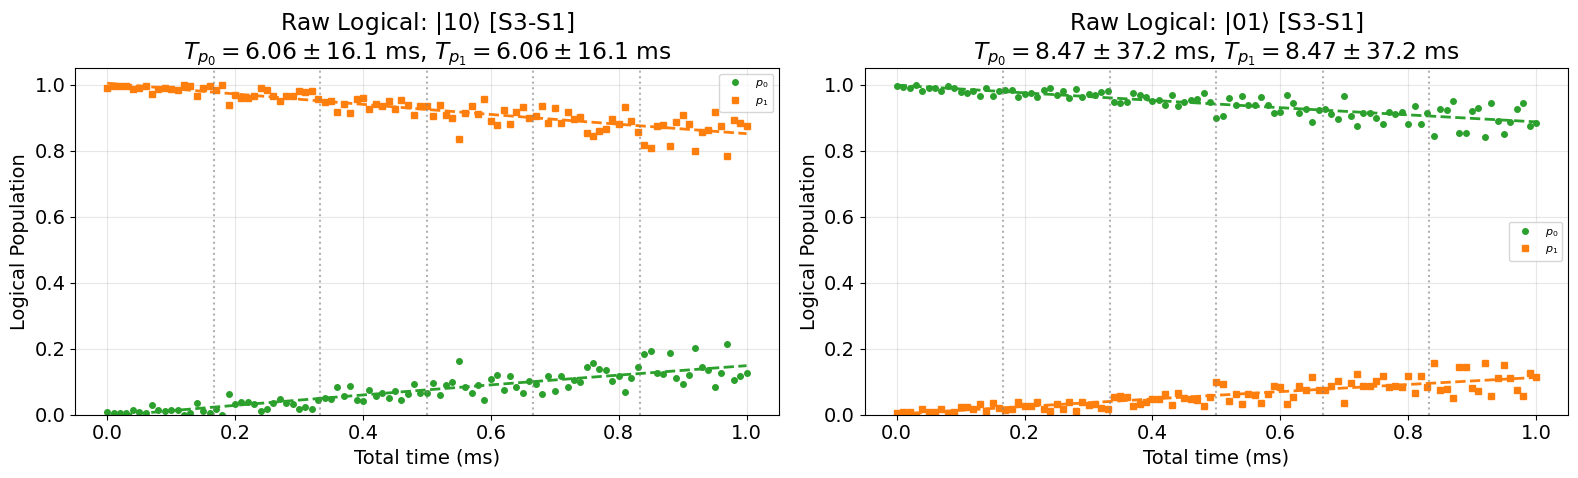

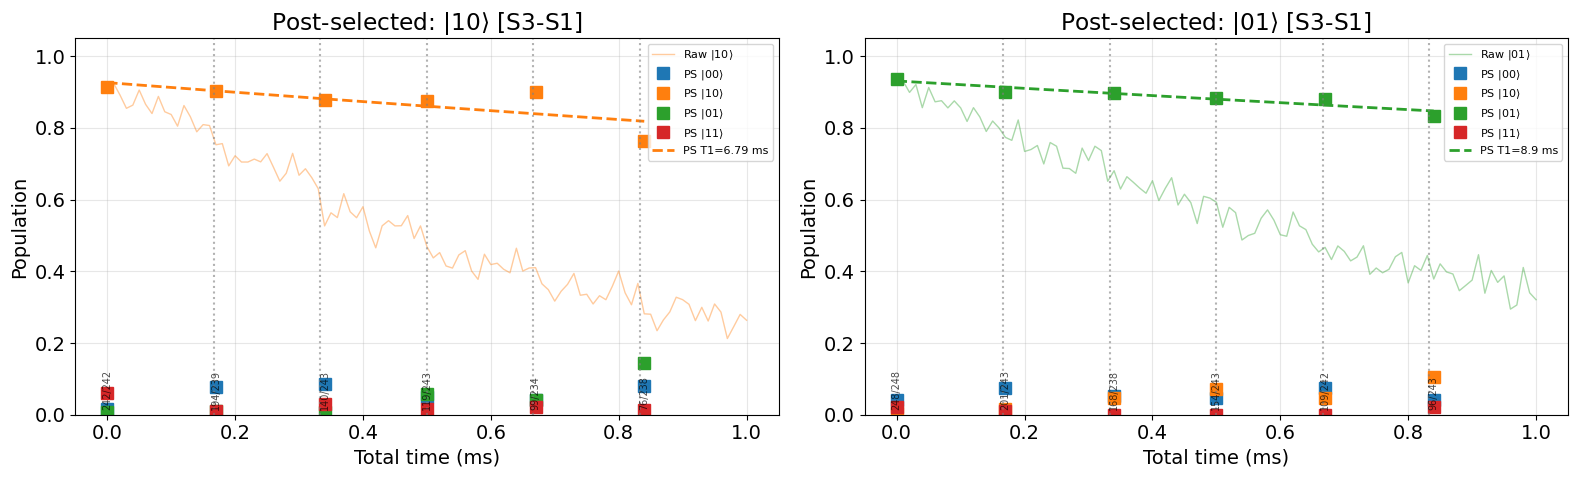

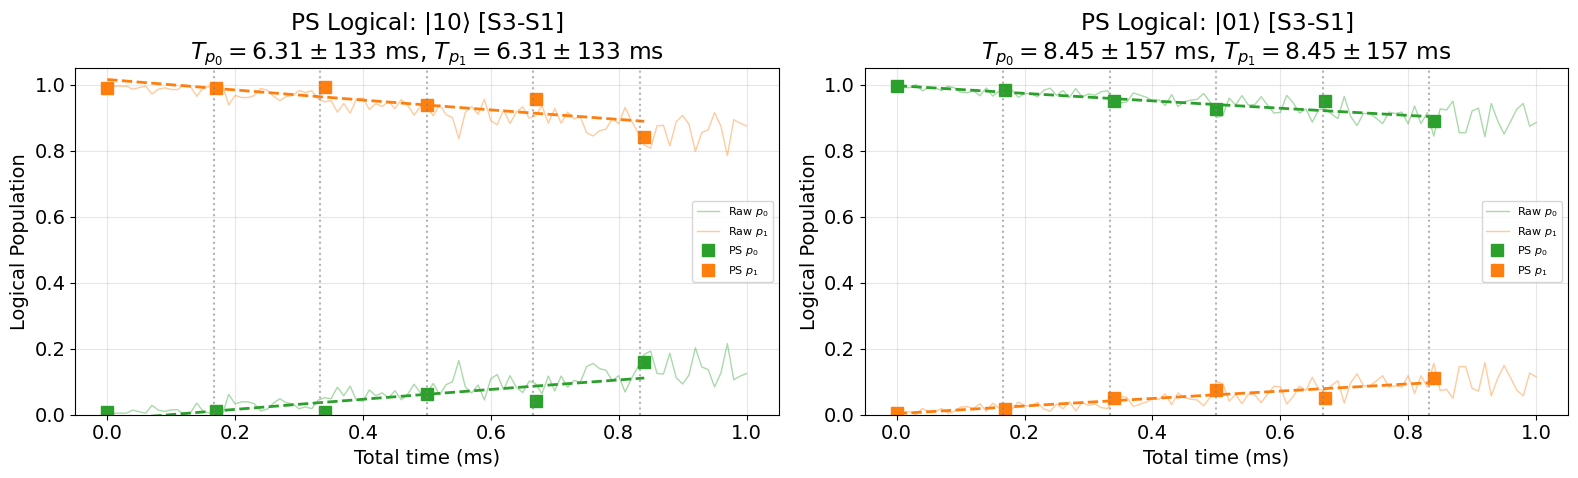

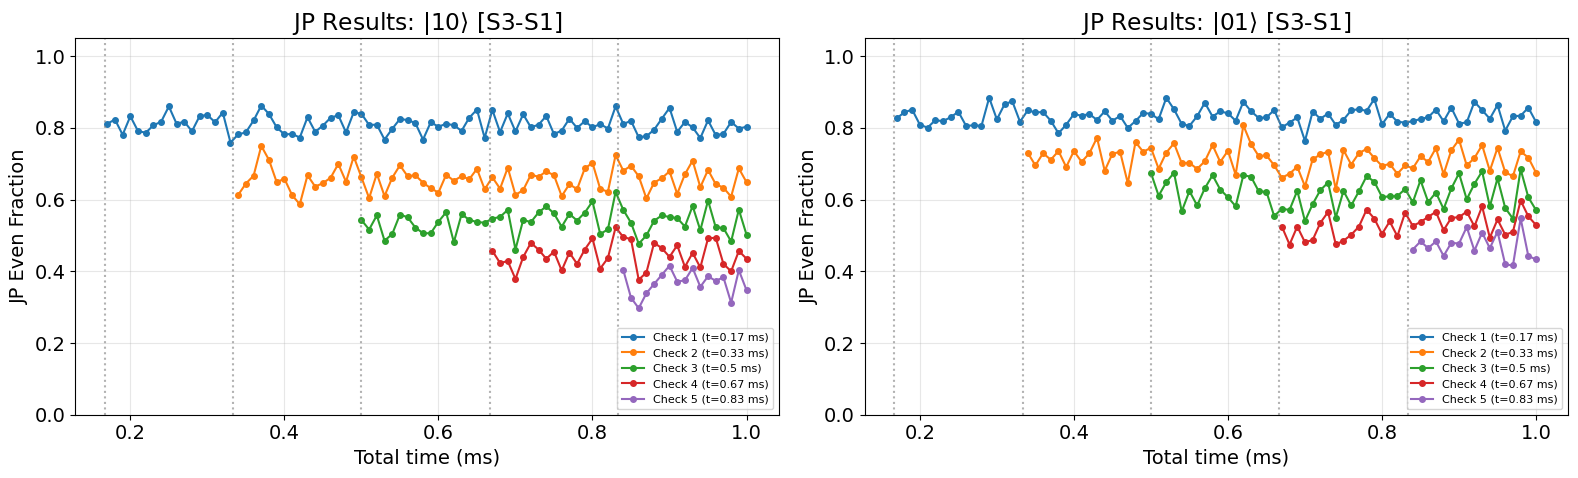

In [9]:
if USE_QUEUE:
    dual_rail_t1_jp1.analyze(post_select=True)
    dual_rail_t1_jp1.display()


# Sandbox V2

In [22]:
# ============================================
# Dual Rail Sandbox V2 - Flexible Multi-Pair
# ============================================

# 1. Define defaults
dual_rail_sandbox_v2_defaults = AttrDict(dict(
    # Averaging
    reps=1000,
    rounds=1,
    # Manipulate mode
    manipulate=1,
    # Dual rail pairs (parallel lists, index = pair)
    storage_swap=[3, 4, 7],
    storage_parity=[1, 2, 6],
    # State prep per pair: '0', '1', '+', '-', '+i', '-i'
    state_start=['1', '+', '0'],
    # Pulse sequence: list of (op_name, arg) tuples
    pulse_sequence=[
        ('wait', 10),
        ('joint_parity', 0),
    ],
    # Which pairs to measure (default: all)
    measure_pairs=[0, 1, 2],
    # Parity options
    parity_fast=False,
    measure_parity=True,
    # Reset options
    active_reset=False,
    reset_before_dual_rail=False,
    reset_after_dual_rail=False,
    # Qubit selection
    qubits=[0],
    relax_delay=10000,
))


def dual_rail_sandbox_v2_postproc(station, expt):
    expt.analyze(post_select=True)
    for pair_idx in expt.cfg.expt.measure_pairs:
        pops = expt.data.get(f'pop_p{pair_idx}', {})  # <-- fixed
        print(f"Pair {pair_idx}: 00={pops.get('00',0):.3f}, 10={pops.get('10',0):.3f}, "
              f"01={pops.get('01',0):.3f}, 11={pops.get('11',0):.3f}")

# 3. Create the runner
dual_rail_sandbox_v2_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.DualRailSandboxV2Experiment,
    default_expt_cfg=dual_rail_sandbox_v2_defaults,
    postprocessor=dual_rail_sandbox_v2_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)


Testing Dual Rail Sandbox V2 with storage_swap=7, storage_parity=6, state_start=00
Job submitted: JOB-20260224-00364 (queue position: 1)

[0.1s] Job JOB-20260224-00364: pending

[2.1s] Job JOB-20260224-00364: running
[WORKER] Loading DualRailSandboxV2Experiment from experiments.dual_rail.dual_rail_sandbox_v2
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00364_DualRailSandboxV2Experiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Dual Rail Sandbox V2: 1 pairs, states=['00'], sequence=1 ops, measuring pairs [0]
Playing swap pulse for storage  7
Performing parity measurement for storage  7
needs a pretty long sync here due to the measurement
Playing swap pulse for storage  6
Performing parity measurement for storage  6
Playing swap back pulse for storage  6
Phase tracking ON: AC Stark rates=[0.1181] MHz
 94%|███████████████████████████████████▌  | 4680/5

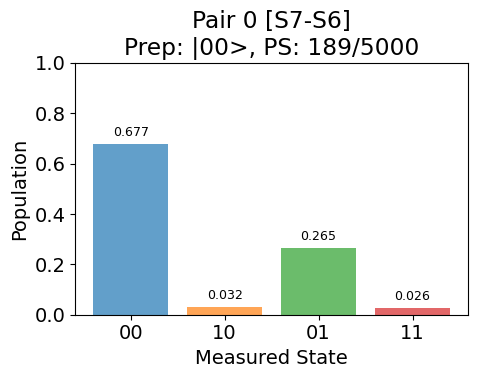

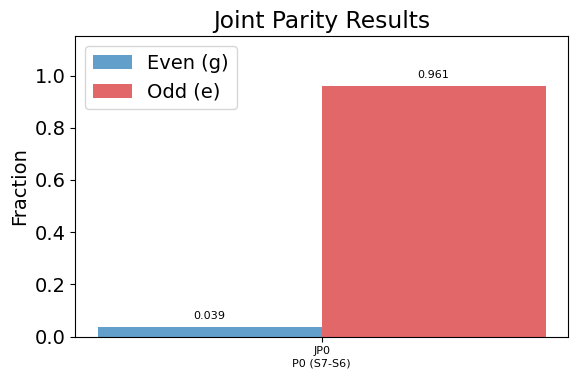

Testing Dual Rail Sandbox V2 with storage_swap=7, storage_parity=6, state_start=01
Job submitted: JOB-20260224-00365 (queue position: 1)

[0.1s] Job JOB-20260224-00365: pending

[2.1s] Job JOB-20260224-00365: running
[WORKER] Loading DualRailSandboxV2Experiment from experiments.dual_rail.dual_rail_sandbox_v2
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00365_DualRailSandboxV2Experiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Dual Rail Sandbox V2: 1 pairs, states=['01'], sequence=1 ops, measuring pairs [0]
prepulse seq: [['multiphoton', 'g0-e0', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0], ['multiphoton', 'f0-g1', 'pi', 0], ['storage', 'M1-S6', 'pi', 0]]
Playing swap pulse for storage  7
Performing parity measurement for storage  7
needs a pretty long sync here due to the measurement
Playing swap pulse for storage  6
Performing parity measurement f

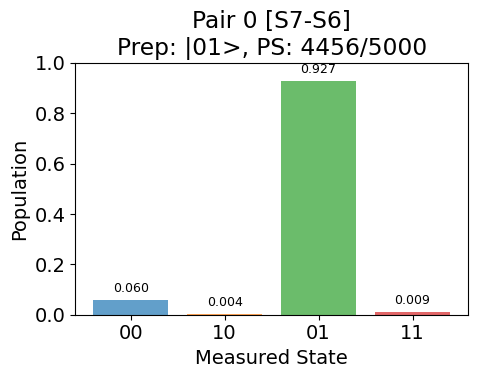

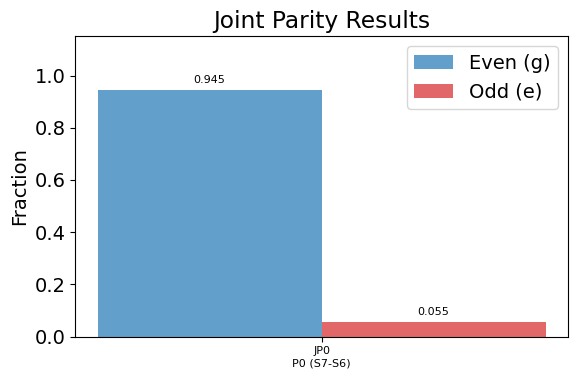

Testing Dual Rail Sandbox V2 with storage_swap=7, storage_parity=6, state_start=10
Job submitted: JOB-20260224-00366 (queue position: 1)

[0.1s] Job JOB-20260224-00366: pending

[2.1s] Job JOB-20260224-00366: running
[WORKER] Loading DualRailSandboxV2Experiment from experiments.dual_rail.dual_rail_sandbox_v2
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00366_DualRailSandboxV2Experiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Dual Rail Sandbox V2: 1 pairs, states=['10'], sequence=1 ops, measuring pairs [0]
prepulse seq: [['multiphoton', 'g0-e0', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0], ['multiphoton', 'f0-g1', 'pi', 0], ['storage', 'M1-S7', 'pi', 0]]
Playing swap pulse for storage  7
Performing parity measurement for storage  7
needs a pretty long sync here due to the measurement
Playing swap pulse for storage  6
Performing parity measurement f

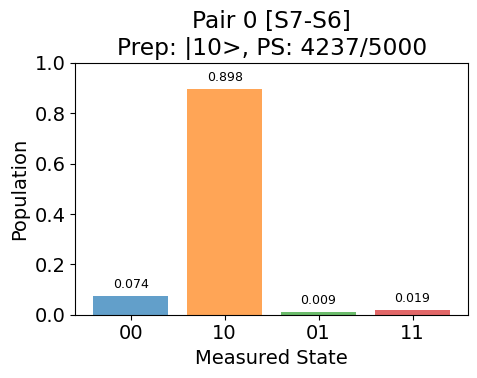

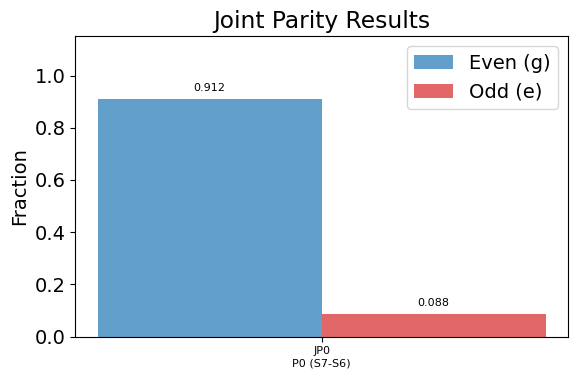

In [36]:
# Example 1: Simple state prep test — prepare |1>, |+>, |0> on 3 pairs, measure immediately

state_prep = ['00', '01', '10']
# storage_swap = [3, 4, 7]
# storage_parity = [1, 2, 6]

storage_swap = [7]
storage_parity = [6]

for s1, s2, in zip(storage_swap, storage_parity):
    for state in state_prep:
        print(f"Testing Dual Rail Sandbox V2 with storage_swap={s1}, storage_parity={s2}, state_start={state}")

        dual_rail_v2_expt = dual_rail_sandbox_v2_runner.execute(
            storage_swap=[s1],
            storage_parity=[s2],
            state_start=[state],
            measure_pairs=[0],
            pulse_sequence=[(('joint_parity', 0))],
            # pulse_sequence=[('wait', 0.1), ('X/2', 0)],           
            reps=5000,
            go_kwargs=dict(analyze=False, display=False),
            **active_reset_dict,
            state_prep_postselect=True
        )

        if USE_QUEUE:
            dual_rail_v2_expt.analyze(post_select=True)
            dual_rail_v2_expt.display()


## Error amplification (not working well)

In [42]:
# ── Configuration ──
N_list = np.arange(0, 5)  # more points for better fit
reps = 1000

# Which pair is being JP'd (the "source" pair)
jp_swap = 1
jp_parity = 3

# Which pair is being measured (the "affected" pair)
# Set equal to jp pair for self-phase, different for cross-pair
meas_swap = 1
meas_parity = 3

is_self = (meas_swap == jp_swap and meas_parity == jp_parity)

# ── Acquire ──
pop_01_list = []
pop_10_list = []


In [43]:
for N in N_list:
    if is_self:
        # Self-phase: JP and measure on the same pair (index 0)
        seq = [('joint_parity', 0)] * int(N) + [('X/2', 0)]
        expt = dual_rail_sandbox_v2_runner.execute(
            storage_swap=[meas_swap],
            storage_parity=[meas_parity],
            state_start=['+'],
            pulse_sequence=seq,
            measure_pairs=[0],
            reps=reps,
            phase_tracking=True,  # Disable phase tracking for self-phase
            go_kwargs=dict(analyze=False, display=False),
            **active_reset_dict,
        )
    else:
        # Cross-phase: JP on pair 0, prepare and measure pair 1
        seq = [('joint_parity', 0)] * int(N) + [('X/2', 1)]
        expt = dual_rail_sandbox_v2_runner.execute(
            storage_swap=[jp_swap, meas_swap],
            storage_parity=[jp_parity, meas_parity],
            state_start=['+', '+'],  # both in |+>
            pulse_sequence=seq,
            measure_pairs=[1],  # measure the affected pair
            reps=reps,
            go_kwargs=dict(analyze=False, display=False),
            **active_reset_dict,
        )

    if USE_QUEUE:
        expt.analyze(post_select=True)

    pop_key = 'pop_p1' if not is_self else 'pop_p0'
    pops = expt.data.get(pop_key, {})
    pop_01_list.append(pops.get('01', 0))
    pop_10_list.append(pops.get('10', 0))
    print(f"N={int(N):2d}: |01>={pops.get('01',0):.3f}, |10>={pops.get('10',0):.3f}")



Job submitted: JOB-20260224-00133 (queue position: 1)

[0.2s] Job JOB-20260224-00133: pending

[2.2s] Job JOB-20260224-00133: running
[WORKER] Loading DualRailSandboxV2Experiment from experiments.dual_rail.dual_rail_sandbox_v2
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00133_DualRailSandboxV2Experiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Dual Rail Sandbox V2: 1 pairs, states=['+'], sequence=1 ops, measuring pairs [0]
Playing swap pulse for storage  1
Performing parity measurement for storage  1
needs a pretty long sync here due to the measurement
Playing swap pulse for storage  3
Performing parity measurement for storage  3
Playing swap back pulse for storage  3
Phase tracking ON: AC Stark rates=[0.05] MHz
  Gate X/2 on pair 0: phase_offset=0.00 deg
 65%|█████████████████████████▌             | 654/1000 [00:06<00:03, 99.57it/s]
[18.3s] Job J


Phase per JP on S1-S3 → S1-S3: 91.11 +/- 0.52 deg


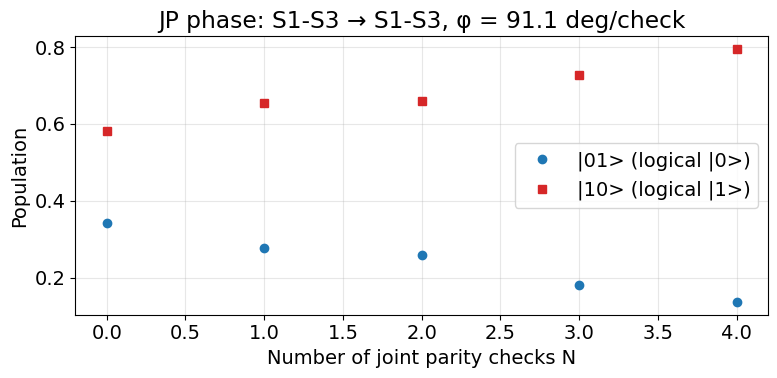

In [45]:
pop_01 = np.array(pop_01_list)
pop_10 = np.array(pop_10_list)

# ── Fit ──
def cos_model(n, A, phi, phi0, B):
    return A * np.cos(phi * n + phi0) + B

p0 = [0.5, 0.3, 0, 0.5]
# popt, pcov = curve_fit(cos_model, N_list, pop_01, p0=p0)
A_fit, phi_fit, phi0_fit, B_fit = popt
perr = np.sqrt(np.diag(pcov))

phase_deg = np.degrees(phi_fit)
phase_deg_err = np.degrees(perr[1])

source_name = f'S{jp_swap}-S{jp_parity}'
affected_name = f'S{meas_swap}-S{meas_parity}'

print(f"\nPhase per JP on {source_name} → {affected_name}: "
      f"{phase_deg:.2f} +/- {phase_deg_err:.2f} deg")

# ── Plot ──
N_fine = np.linspace(N_list[0], N_list[-1], 200)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(N_list, pop_01, 'o', label='|01> (logical |0>)', color='tab:blue')
ax.plot(N_list, pop_10, 's', label='|10> (logical |1>)', color='tab:red')
# ax.plot(N_fine, cos_model(N_fine, *popt), '-', color='tab:blue', alpha=0.7)
ax.set_xlabel('Number of joint parity checks N')
ax.set_ylabel('Population')
ax.set_title(f'JP phase: {source_name} → {affected_name}, '
             f'φ = {phase_deg:.1f} deg/check')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

## JP phase calibration using X/Y tomography

Job submitted: JOB-20260224-00288 (queue position: 1)

[0.1s] Job JOB-20260224-00288: pending

[20.4s] Job JOB-20260224-00288: running
[WORKER] Loading DualRailSandboxV2Experiment from experiments.dual_rail.dual_rail_sandbox_v2
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260224-00288_DualRailSandboxV2Experiment.h5
[WORKER] Running experiment...
[WORKER] Setting coupler yoko current to 0.5mA according to hardware_cfg yaml...
[WORKER] Done setting coupler current
Dual Rail Sandbox V2: 1 pairs, states=['+'], sequence=1 ops, measuring pairs [0]
Playing swap pulse for storage  3
Performing parity measurement for storage  3
needs a pretty long sync here due to the measurement
Playing swap pulse for storage  1
Performing parity measurement for storage  1
Playing swap back pulse for storage  1
Phase tracking ON: AC Stark rates=[0.05] MHz
  Gate X/2 on pair 0: phase_offset=0.00 deg
 92%|██████████████████████████████████▊   | 4578/5000 [00:45<00:04, 99.58it/s]
[75.5s] Job 

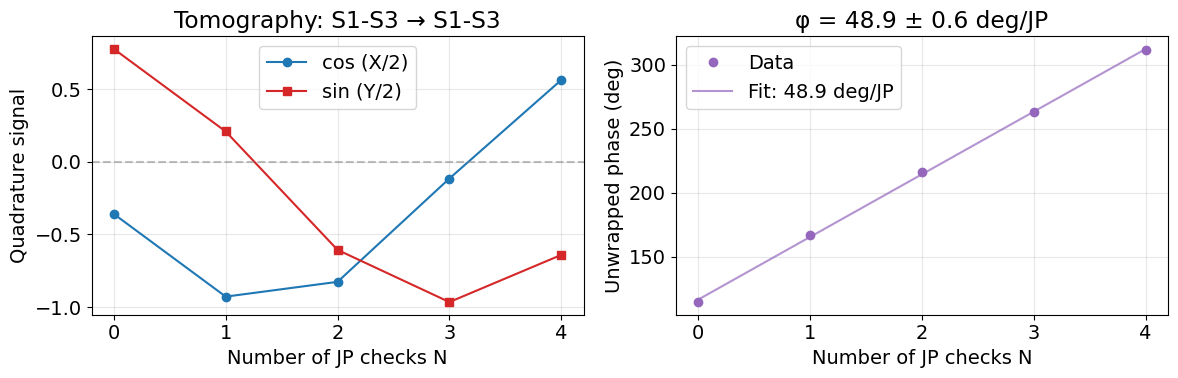

In [116]:
reps = 5000
jp_swap = 3
jp_parity = 1
meas_swap = jp_swap
meas_parity = jp_parity

source_name = station.ds_storage.pair_name(jp_swap, jp_parity)
affected_name = station.ds_storage.pair_name(meas_swap, meas_parity)
is_self = (meas_swap == jp_swap and meas_parity == jp_parity)

N_list = np.arange(0, 5)

# ── Acquire ──
phase_list = []
cos_list = []
sin_list = []

for N_jp in N_list:
    gate_results = {}
    for gate in ['X/2', 'Y/2']:
        if is_self:
            seq = [('joint_parity', 0)] * int(N_jp) + [(gate, 0)]
            expt = dual_rail_sandbox_v2_runner.execute(
                storage_swap=[meas_swap],
                storage_parity=[meas_parity],
                state_start=['+'],
                pulse_sequence=seq,
                measure_pairs=[0],
                reps=reps,
                go_kwargs=dict(analyze=False, display=False),
                **active_reset_dict,
            )
        else:
            seq = [('joint_parity', 0)] * int(N_jp) + [(gate, 1)]
            expt = dual_rail_sandbox_v2_runner.execute(
                storage_swap=[jp_swap, meas_swap],
                storage_parity=[jp_parity, meas_parity],
                state_start=['+', '+'],
                pulse_sequence=seq,
                measure_pairs=[1],
                reps=reps,
                go_kwargs=dict(analyze=False, display=False),
                **active_reset_dict,
            )

        if USE_QUEUE:
            expt.analyze(post_select=True)

        pop_key = 'pop_p0' if is_self else 'pop_p1'
        pops = expt.data.get(pop_key, {})
        gate_results[gate] = pops.get('01', 0.5)
        print(f"N={int(N_jp):2d}, {gate}: |01>={pops.get('01',0):.3f}, |10>={pops.get('10',0):.3f}")

    c = 2 * gate_results['X/2'] - 1
    s = 2 * gate_results['Y/2'] - 1
    cos_list.append(c)
    sin_list.append(s)
    phase_list.append(np.arctan2(s, c))

phase_arr = np.unwrap(phase_list)  # unwrap for linear fit

# ── Linear fit: phase(N) = φ_per_JP * N + φ_offset ──
def linear(n, phi_per_jp, phi0):
    return phi_per_jp * n + phi0

popt, pcov = curve_fit(linear, N_list, phase_arr)
phi_per_jp_rad, phi0_rad = popt
perr = np.sqrt(np.diag(pcov))

phase_per_jp_deg = np.degrees(phi_per_jp_rad) % 360
phase_per_jp_err = np.degrees(perr[0])

print(f"\nPhase per JP on {source_name} → {affected_name}: "
      f"{phase_per_jp_deg:.2f} +/- {phase_per_jp_err:.2f} deg")

# ── Plot ──
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: X/Y quadratures vs N
axes[0].plot(N_list, cos_list, 'o-', label='cos (X/2)', color='tab:blue')
axes[0].plot(N_list, sin_list, 's-', label='sin (Y/2)', color='tab:red')
axes[0].set_xlabel('Number of JP checks N')
axes[0].set_ylabel('Quadrature signal')
axes[0].set_title(f'Tomography: {source_name} → {affected_name}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='gray', ls='--', alpha=0.5)

# Right: unwrapped phase + linear fit
N_fine = np.linspace(N_list[0], N_list[-1], 200)
axes[1].plot(N_list, np.degrees(phase_arr), 'o', color='tab:purple', label='Data')
axes[1].plot(N_fine, np.degrees(linear(N_fine, *popt)), '-', color='tab:purple',
             alpha=0.7, label=f'Fit: {phase_per_jp_deg:.1f} deg/JP')
axes[1].set_xlabel('Number of JP checks N')
axes[1].set_ylabel('Unwrapped phase (deg)')
axes[1].set_title(f'φ = {phase_per_jp_deg:.1f} ± {phase_per_jp_err:.1f} deg/JP')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()


In [117]:
# ── Save (add to existing calibration) ──
ds = station.ds_storage
phase_dict = ds.get_dr_jp_phase(affected_name) or {}
existing = phase_dict.get(source_name, 0.0)
phase_dict[source_name] = (existing + phase_per_jp_deg) % 360
ds.update_dr_jp_phase(affected_name, phase_dict)
print(f"Saved: {affected_name}.dr_jp_phase[{source_name}] = "
      f"{existing:.1f} + {phase_per_jp_deg:.1f} = {phase_dict[source_name]:.1f} deg")


Saved: S1-S3.dr_jp_phase[S1-S3] = 266.4 + 48.9 = 315.3 deg


In [113]:
station.snapshot_man1_storage_swap(update_main=True)

[CONFIG] Created new man1_storage_swap version CFG-M1-20260224-00019
[CONFIG] Updated main man1_storage_swap to CFG-M1-20260224-00019


'CFG-M1-20260224-00019'

In [41]:
# ── Save ──
ds = station.ds_storage
phase_dict = ds.get_dr_jp_phase(affected_name) or {}
phase_dict[source_name] = phase_per_jp_deg
ds.update_dr_jp_phase(affected_name, phase_dict)
print(f"Saved: {affected_name}.dr_jp_phase = {phase_dict}")

Saved: S1-S3.dr_jp_phase = {'S1-S3': 273.85843687007934}


In [19]:
station.ds_storage.df

stor_name   freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1   352.805051              NaN   2.352172    1.176086   
1      M1-S2   524.652187              NaN   2.066902    1.153536   
2      M1-S3   700.803778              NaN   1.696505    0.848253   
3      M1-S4   880.746898              NaN   2.347447    1.173723   
4      M1-S5  1057.057548              NaN   2.833119    1.416560   
5      M1-S6  1248.744297              NaN   2.236056    0.902242   
6      M1-S7  1426.866000              NaN   2.983754    1.491877   
7      M1-S8    -1.000000            -1.00  -1.000000   -1.000000   
8      M1-S9    -1.000000            -1.00  -1.000000   -1.000000   
9     M1-S10    -1.000000            -1.00  -1.000000   -1.000000   
10    M1-S11    -1.000000            -1.00  -1.000000   -1.000000   
11    M1-S12    -1.000000            -1.00  -1.000000   -1.000000   
12        M1  1998.642844              NaN   0.577254    0.283179   
13        M2  1834.950000             0.01   1.054456    0.520515   
14     M2-S1   175.630000             0.01   2.173484    1.086742   
15     M2-S2   346.840000             0.01   0.908835    0.454417   
16     M2-S3   523.220000             0.01   1.561615    0.780808   
17     M2-S4   702.650000             0.01   1.386764    0.693382   
18     M2-S5   878.780000             0.01   1.303372    0.651686   
19     M2-S6  1070.100000             0.01   2.379622    1.189811   
20     M2-S7  1249.700000             0.01   1.796981    0.898491   
21     M2-M1   173.790000             0.01   0.463481    0.231741   
22     M1-D2  2271.934513             0.01  60.581349   30.290674   
23     M2-D2  2094.050000             0.01  15.000000    0.000000   
24      M1-C   919.000000             0.02   0.251127    0.122354   
25     M1_ce  2008.780000             0.02   0.617915    0.304523   
26     S1-S3    -1.000000            -1.00  -1.000000   -1.000000   
27     S2-S4    -1.000000            -1.00  -1.000000   -1.000000   
28     S6-S7    -1.000000            -1.00  -1.000000   -1.000000   

    gain (DAC units)                 last_update  \
0             3201.0  2026-02-21 23:35:47.466753   
1             4127.0  2026-02-21 22:41:57.396769   
2             4706.0  2026-02-22 15:09:06.016050   
3             5758.0  2026-02-21 14:46:37.560548   
4             6123.0  2026-02-21 15:08:17.529746   
5            10403.0  2026-02-21 21:32:38.385875   
6             9904.0  2026-02-21 13:51:03.918597   
7               -1.0                     51:31.3   
8               -1.0                     51:31.3   
9               -1.0                     51:31.3   
10              -1.0                     51:31.3   
11              -1.0                     51:31.3   
12            8000.0  2026-01-19 11:06:42.086262   
13           15000.0  2025-04-30 11:22:11.432806   
14            1000.0                     28:20.8   
15            5000.0                     33:56.1   
16            5000.0                     22:30.3   
17            9000.0                     25:33.1   
18           13500.0                     00:05.4   
19            9000.0                     30:59.0   
20           12000.0                     56:07.5   
21            2000.0  2024-10-06 01:47:25.946153   
22           32000.0  2026-02-18 11:58:52.011013   
23            8000.0  2025-01-23 17:22:53.776061   
24            1000.0  2025-12-08 16:40:53.078714   
25           15000.0  2025-01-20 09:52:35.311227   
26              -1.0  2026-02-24 08:14:26.858280   
27              -1.0  2026-02-24 07:33:59.920302   
28              -1.0  2026-02-24 07:33:59.920302   

                                     bs_rate_coeffs_g  \
0   [-1.2836395105770435e-12, 1.562696017091276e-0...   
1   [-1.4281651019406063e-14, 2.806388588329146e-1...   
2   [5.6421716124194476e-14, -9.54652575391602e-10...   
3   [1.3074330883632018e-13, -3.895577532599537e-0...   
4                                                 NaN   
5   [-1.3966876001204708e-16,